# 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas.util.testing as tm

import plotly.express as px
import plotly.offline as py

import folium

from folium import plugins
from datetime import date, timedelta

<ipython-input-1-6147a65750f3>:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import matplotlib.font_manager as fm

font_location ='C:\Windows\Fonts\gulim.ttc'
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family = font_name)

# 데이터셋 가져오기

In [3]:
case= pd.read_csv("./data/Case.csv")
patient_info = pd.read_csv("./data/PatientInfo.csv")
# patient_route = pd.read_csv("./data/PatientRoute.csv")  # 신규데이터에는 해당 파일 누락되어 있음
region = pd.read_csv("./data/region.csv")
search_trend= pd.read_csv("./data/SearchTrend.csv")
floating = pd.read_csv("./data/SeoulFloating.csv")
time= pd.read_csv("./data/Time.csv")
time_age= pd.read_csv("./data/TimeAge.csv")
time_gender= pd.read_csv("./data/TimeGender.csv")
time_province= pd.read_csv("./data/TimeProvince.csv")
weather= pd.read_csv("./data/Weather.csv")
seoulfloating = pd.read_csv("./data/SeoulFloating.csv")
policy = pd.read_csv("./data/Policy.csv")

# 정현우 데이터 검증
sf_2002 = pd.read_csv('./유동인구 데이터/Floating_Population_2002.csv')
sf_2003 = pd.read_csv('./유동인구 데이터/Floating_Population_2003.csv')
sf_2005 = pd.read_csv('./유동인구 데이터/Floating_Population_2005.csv')


pd.set_option('display.max_rows', 100)

# 유동인구 Data 검증

### 2월 23일 데이터 검증
- 다른 2월 유동인구 데이터보다 유동인구수가 월등히 높음
- 서울의 전체 구에서 다른 날과 2월 23일의 데이터간의 차이 분석
- 송파구를 대표 데이터로 선정하여 데이터 비교

In [4]:
# 2/23일과 2월 평균치 비교
# 2/23일 각 구별 유동인구수 Dataframe으로 만들기
is_sf_200223 = sf_2002['일자'] == 20200223
sf_200223 = sf_2002[is_sf_200223]

sf_200223_floating = sf_200223.groupby(['군구'])[['유동인구수']].sum().sort_values(by=['군구'], axis=0, ascending=True)
sf_200223_floating = sf_200223_floating.rename(columns={'유동인구수' : '2/23일 유동인구수'})

# ------------------------------------------------------------------------------------------------------------
# 2/23일을 제외한 나머지 일자의 유동인구수 평균 Dataframe으로 만들기
sf_2002_mean = sf_2002[sf_2002['일자'] != 20200223]
sf_2002_mean = sf_2002_mean.groupby(['군구'])[['유동인구수']].sum().sort_values(by=['군구'], axis=0, ascending=True)
sf_2002_mean = sf_2002_mean.rename(columns={'유동인구수' : '2월 평균 유동인구수'})

sf_2002_mean['2월 평균 유동인구수'] = sf_2002_mean.apply(lambda x : x//28)

# -----------------------------------------------------------------------------------------------------------------------
# 2/23일 유동인구수와 나머지 일자의 DataFrame 합치기
sf_2002_outlier = pd.concat([sf_200223_floating, sf_2002_mean], axis=1)

# 타입을 int로 변경하기
sf_2002_outlier.astype({'2/23일 유동인구수':'int', '2월 평균 유동인구수':'int'}).dtypes

# 유동인구수 차이 인구수를 구해서 신규 열 만들기
sf_2002_outlier['차이(2/23 - 평균)'] = sf_2002_outlier['2/23일 유동인구수'] - sf_2002_outlier['2월 평균 유동인구수']

# 유동인구수 차이를 %로 표현하고 신규 열 만들기
sf_2002_outlier['(2/23 / 평균), %'] = (sf_2002_outlier['2/23일 유동인구수'] / sf_2002_outlier['2월 평균 유동인구수'] * 100 - 100)

# 열별 합계값을 col_sum 변수에 넣은 다음 합계라는 신규 행을 만들어 입력한다
col_sum = sf_2002_outlier.sum(axis=0)
sf_2002_outlier.loc['합 계'] = col_sum

sf_2002_outlier.loc['합 계', '차이(2/23 - 평균)'] = sf_2002_outlier.loc['합 계', '2/23일 유동인구수'] - sf_2002_outlier.loc['합 계', '2월 평균 유동인구수'] 
sf_2002_outlier.loc['합 계', '(2/23 / 평균), %'] = sf_2002_outlier.loc['합 계', '2/23일 유동인구수'] / sf_2002_outlier.loc['합 계', '2월 평균 유동인구수'] *100 -100


# 평균을 int type으로 변경 -> 소수점을 표기해야하므로 주석처리(09. 07)
# sf_2002_outlier.astype({'(2/23 / 평균), %':'int'}).dtypes

# 각각의 표기법을 1,000단위에서 쉼표로 구분해주고, %는 소수점 둘째자리까지 표기
# sf_2002_outlier['2/23일 유동인구수'] = sf_2002_outlier.apply(lambda x : "{:,}".format(int(x['2/23일 유동인구수'])), axis=1)
# sf_2002_outlier['2월 평균 유동인구수'] = sf_2002_outlier.apply(lambda x : "{:,}".format(int(x['2월 평균 유동인구수'])), axis=1)
# sf_2002_outlier['차이(2/23 - 평균)'] = sf_2002_outlier.apply(lambda x : "{:,}".format(int(x['차이(2/23 - 평균)'])), axis=1)
# sf_2002_outlier['(2/23 / 평균), %'] = sf_2002_outlier.apply(lambda x : "{:.2f}".format(float(x['(2/23 / 평균), %'])), axis=1)


sf_2002_outlier


,2/23일 유동인구수,2월 평균 유동인구수,차이(2/23 - 평균),"(2/23 / 평균), %"
군구,,,,
강남구,22079620.0,14516980.0,7562640.0,52.095133
강동구,16304330.0,7956928.0,8347402.0,104.907346
강북구,11871100.0,5662667.0,6208433.0,109.637967
강서구,21131690.0,10577971.0,10553719.0,99.770731
관악구,19802120.0,9420988.0,10381132.0,110.191543
광진구,13911300.0,6803519.0,7107781.0,104.472127
구로구,16582310.0,8507494.0,8074816.0,94.914155
금천구,9618100.0,5500128.0,4117972.0,74.870476
노원구,19767110.0,9447118.0,10319992.0,109.239580


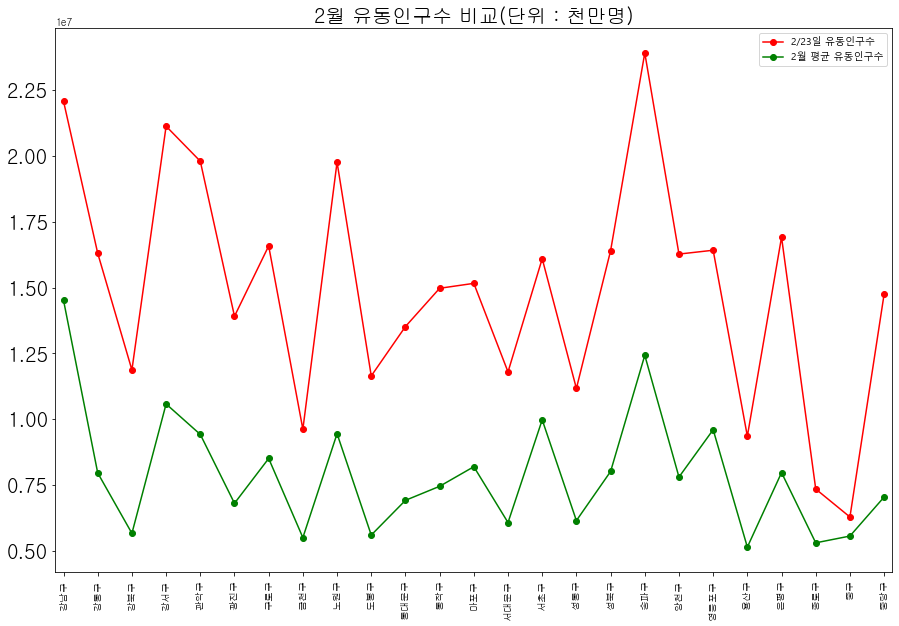

In [5]:
plot_y1 = sf_2002_outlier['2/23일 유동인구수'].iloc[0:-1]
plot_y2 = sf_2002_outlier['2월 평균 유동인구수'].iloc[0:-1]

plot_x1 = list(sf_2002_outlier.index)
plot_x1 = plot_x1[0:-1]

fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=20)
plt.margins(x=0.01)
plt.title("2월 유동인구수 비교(단위 : 천만명)", fontsize=20)

ax.plot(plot_x1, plot_y1, label = '2/23일 유동인구수', color='red', marker='o', linestyle = '-')
ax.plot(plot_x1, plot_y2, label = '2월 평균 유동인구수', color='green', marker='o', linestyle = '-')

plt.rc('font', family='Malgun Gothic')

plt.legend(loc='best')
plt.show()

In [6]:
# 이상치 데이터 세부 내용
# 송파구가 특별히 데이터 차이가 많이 났으므로 시간대별로 얼마나 차이가 났는지 Data Frame 작성
# 2/23일 송파구 데이터 작성
is_sf_songfa = sf_200223['군구'] == '송파구'

# 데이터 정렬
sf_songfa = sf_200223[is_sf_songfa].sort_values(by=['시간(1시간단위)', '연령대(10세단위)', '성별'], axis=0, ascending=True)

# 2/23일을 제외한 송파구의 시간대별 유동인구수 체크
# sf_2002에서 송파구만 추출해서 DataFrame 저장
is_sf_2002_songfa = sf_2002[sf_2002['군구'] == '송파구' ]

# 2/23일을 제외하고 DataFrame 저장
sf_2002_songfa = is_sf_2002_songfa[is_sf_2002_songfa['일자'] != 20200223]

# 저장된 데이터를 나중에 합치기 위해 정렬
sf_2002_songfa = sf_2002_songfa.groupby(['시간(1시간단위)', '연령대(10세단위)', '성별'])[['유동인구수']].sum().sort_values(by=['시간(1시간단위)', '연령대(10세단위)', '성별'], axis=0, ascending=True)

# 유동인구수라는 열 이름이 겹칠 수 있으므로 열 이름 정리
sf_2002_songfa = sf_2002_songfa.rename(columns = {'유동인구수' : '2월 송파구 평균 유동인구수'})

# 데이터를 비교해야하므로 1일 평균 데이터 확보를 위해 28일로 나눔
sf_2002_songfa = sf_2002_songfa.apply(lambda x : x // 28)

# 별도의 시리즈로 분리(값만 빼서 Data Frame에 넣기 위해)
series_sf_2002_songfa = pd.Series(sf_2002_songfa['2월 송파구 평균 유동인구수'])

# 새로운 열을 만들고 거기에 방금 만든 평균 유동인구수 열을 합쳐준다
sf_songfa['2월 송파구 평균 유동인구수'] = series_sf_2002_songfa.values
sf_songfa = sf_songfa.drop(['시', '군구'], axis=1)
sf_songfa = sf_songfa.drop(['일자'], axis=1)

# 열 이름을 겹치지 않도록 수정
sf_songfa = sf_songfa.rename(columns={'유동인구수' : '2/23일 송파구 유동인구수'})

# 차이와 차이비율 신규 열 작성
sf_songfa['차이(2/23 - 평균)'] = sf_songfa['2/23일 송파구 유동인구수'] - sf_songfa['2월 송파구 평균 유동인구수']
sf_songfa['(2/23 / 평균), %'] = sf_songfa['2/23일 송파구 유동인구수'] / sf_songfa['2월 송파구 평균 유동인구수'] * 100 - 100

# 인덱스를 새로 세팅하기 위해 index 숫자 작성해서 적용
idx_num = pd.Index(np.arange(288))
sf_songfa['index'] = idx_num
sf_songfa.set_index('index', inplace=True)


# 합계 행을 만들어서 각 열의 합계를 저장
songfa_sum = sf_songfa.sum(axis=0)
sf_songfa.loc['합계'] = songfa_sum

# 쓸데 없는 열은 빈칸을 입력
sf_songfa.loc['합계', '시간(1시간단위)'] = ''
sf_songfa.loc['합계', '연령대(10세단위)'] = ''
sf_songfa.loc['합계', '성별'] = ''


# 차이와 차이 비율은 합계가 아니라 각각의 열에 맞게 서식 수정
sf_songfa.loc['합계', '차이(2/23 - 평균)'] = sf_songfa.loc['합계', '2/23일 송파구 유동인구수'] - sf_songfa.loc['합계', '2월 송파구 평균 유동인구수'] 
sf_songfa.loc['합계', '(2/23 / 평균), %'] = sf_songfa.loc['합계', '2/23일 송파구 유동인구수'] / sf_songfa.loc['합계', '2월 송파구 평균 유동인구수'] *100 -100

# 1000 단위에서 쉼표로 구분하기 위해 apply 함수를 통해 쉼표 삽입
# sf_songfa = sf_songfa.drop(['(2/23 / 평균)'], axis=1)
# sf_songfa['2/23일 송파구 유동인구수'] = sf_songfa.apply(lambda x : "{:,}".format(int(x['2/23일 송파구 유동인구수'])), axis=1)
# sf_songfa['2월 송파구 평균 유동인구수'] = sf_songfa.apply(lambda x : "{:,}".format(int(x['2월 송파구 평균 유동인구수'])), axis=1)
# sf_songfa['차이(2/23 - 평균)'] = sf_songfa.apply(lambda x : "{:,}".format(int(x['차이(2/23 - 평균)'])), axis=1)
# sf_songfa['(2/23 / 평균), %'] = sf_songfa.apply(lambda x : "{:.2f}".format(float(x['(2/23 / 평균), %'])), axis=1)


sf_songfa

,시간(1시간단위),연령대(10세단위),성별,2/23일 송파구 유동인구수,2월 송파구 평균 유동인구수,차이(2/23 - 평균),"(2/23 / 평균), %"
index,,,,,,,
0,0,20,남성,86570,43256,43314,100.134085
1,0,20,여성,87910,44310,43600,98.397653
2,0,30,남성,107040,54469,52571,96.515449
3,0,30,여성,109690,56577,53113,93.877371
4,0,40,남성,104740,54046,50694,93.797876
...,...,...,...,...,...,...,...
284,23,60,남성,64340,32099,32241,100.442381
285,23,60,여성,66440,33439,33001,98.690152
286,23,70,남성,33920,17086,16834,98.525108


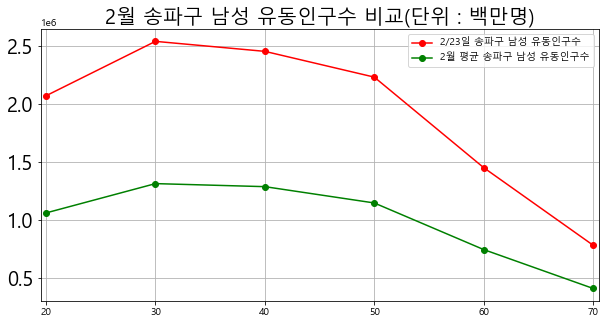

In [7]:
men_sf_songfa = sf_songfa[sf_songfa['성별'] == '남성']
men_sf_songfa = men_sf_songfa.groupby(['연령대(10세단위)'])[['2/23일 송파구 유동인구수', '2월 송파구 평균 유동인구수']].sum()

plot_x1 = men_sf_songfa.index
plot_y1 = men_sf_songfa['2/23일 송파구 유동인구수']
plot_y2 = men_sf_songfa['2월 송파구 평균 유동인구수']

fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation = 0, fontsize=10)
plt.yticks(fontsize=20)
plt.margins(x=0.01)
plt.title("2월 송파구 남성 유동인구수 비교(단위 : 백만명)", fontsize=20)

ax.plot(plot_x1, plot_y1, label = '2/23일 송파구 남성 유동인구수', color='red', marker='o', linestyle = '-')
ax.plot(plot_x1, plot_y2, label = '2월 평균 송파구 남성 유동인구수', color='green', marker='o', linestyle = '-')

plt.rc('font', family='Malgun Gothic')

plt.grid(True)
plt.legend(loc='best')
plt.show()

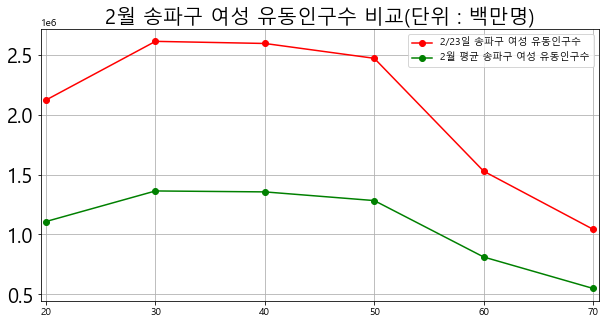

In [8]:
women_sf_songfa = sf_songfa[sf_songfa['성별'] == '여성']
women_sf_songfa = women_sf_songfa.groupby(['연령대(10세단위)'])[['2/23일 송파구 유동인구수', '2월 송파구 평균 유동인구수']].sum()


plot_x1 = women_sf_songfa.index
plot_y1 = women_sf_songfa['2/23일 송파구 유동인구수']
plot_y2 = women_sf_songfa['2월 송파구 평균 유동인구수']

fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation = 0, fontsize=10)
plt.yticks(fontsize=20)
plt.margins(x=0.01)
plt.title("2월 송파구 여성 유동인구수 비교(단위 : 백만명)", fontsize=20)

ax.plot(plot_x1, plot_y1, label = '2/23일 송파구 여성 유동인구수', color='red', marker='o', linestyle = '-')
ax.plot(plot_x1, plot_y2, label = '2월 평균 송파구 여성 유동인구수', color='green', marker='o', linestyle = '-')

plt.rc('font', family='Malgun Gothic')

plt.grid(True)
plt.legend(loc='best')
plt.show()

In [9]:
# 3/11일과 3월 평균치 비교
# 3/11일 각 구별 유동인구수 Dataframe으로 만들기
is_sf_200311 = sf_2003['일자'] == 20200311
sf_200311 = sf_2003[is_sf_200311]

sf_200311_floating = sf_200311.groupby(['군구'])[['유동인구수']].sum().sort_values(by=['군구'], axis=0, ascending=True)
sf_200311_floating = sf_200311_floating.rename(columns={'유동인구수' : '3/11일 유동인구수'})

# ------------------------------------------------------------------------------------------------------------
# 3/11일을 제외한 나머지 일자의 유동인구수 평균 Dataframe으로 만들기
sf_2003_mean = sf_2003[sf_2003['일자'] != 20200311]
sf_2003_mean = sf_2003_mean.groupby(['군구'])[['유동인구수']].sum().sort_values(by=['군구'], axis=0, ascending=True)
sf_2003_mean = sf_2003_mean.rename(columns={'유동인구수' : '3월 평균 유동인구수'})

sf_2003_mean['3월 평균 유동인구수'] = sf_2003_mean.apply(lambda x : x//30)

# -----------------------------------------------------------------------------------------------------------------------
# 3/11일 유동인구수와 나머지 일자의 DataFrame 합치기
sf_2003_outlier = pd.concat([sf_200311_floating, sf_2003_mean], axis=1)

# 타입을 int로 변경하기
sf_2003_outlier.astype({'3/11일 유동인구수':'int', '3월 평균 유동인구수':'int'}).dtypes

# 유동인구수 차이 인구수를 구해서 신규 열 만들기
sf_2003_outlier['차이(3/11 - 평균)'] = sf_2003_outlier['3/11일 유동인구수'] - sf_2003_outlier['3월 평균 유동인구수']

# 유동인구수 차이를 %로 표현하고 신규 열 만들기
sf_2003_outlier['(3/11 / 평균), %'] = (sf_2003_outlier['3/11일 유동인구수'] / sf_2003_outlier['3월 평균 유동인구수'] * 100 - 100)

# 열별 합계값을 col_sum 변수에 넣은 다음 합계라는 신규 행을 만들어 입력한다
col_sum = sf_2003_outlier.sum(axis=0)
sf_2003_outlier.loc['합 계'] = col_sum

sf_2003_outlier.loc['합 계', '차이(3/11 - 평균)'] = sf_2003_outlier.loc['합 계', '3/11일 유동인구수'] - sf_2003_outlier.loc['합 계', '3월 평균 유동인구수'] 
sf_2003_outlier.loc['합 계', '(3/11 / 평균), %'] = sf_2003_outlier.loc['합 계', '3/11일 유동인구수'] / sf_2003_outlier.loc['합 계', '3월 평균 유동인구수'] *100 -100


# 평균을 int type으로 변경 -> 소수점을 표기해야하므로 주석처리(09. 07)
# sf_2003_outlier.astype({'(3/11 / 평균), %':'int'}).dtypes

# 각각의 표기법을 1,000단위에서 쉼표로 구분해주고, %는 소수점 둘째자리까지 표기
# sf_2003_outlier['3/11일 유동인구수'] = sf_2003_outlier.apply(lambda x : "{:,}".format(int(x['3/11일 유동인구수'])), axis=1)
# sf_2003_outlier['3월 평균 유동인구수'] = sf_2003_outlier.apply(lambda x : "{:,}".format(int(x['3월 평균 유동인구수'])), axis=1)
# sf_2003_outlier['차이(3/11 - 평균)'] = sf_2003_outlier.apply(lambda x : "{:,}".format(int(x['차이(3/11 - 평균)'])), axis=1)
# sf_2003_outlier['(3/11 / 평균), %'] = sf_2003_outlier.apply(lambda x : "{:.2f}".format(float(x['(3/11 / 평균), %'])), axis=1)


sf_2003_outlier

,3/11일 유동인구수,3월 평균 유동인구수,차이(3/11 - 평균),"(3/11 / 평균), %"
군구,,,,
강남구,11746450.0,13247090.0,-1500640.0,-11.328073
강동구,6358550.0,7774545.0,-1415995.0,-18.213220
강북구,4480560.0,5527013.0,-1046453.0,-18.933428
강서구,8460910.0,10239539.0,-1778629.0,-17.370206
관악구,7466750.0,9178947.0,-1712197.0,-18.653523
광진구,5427140.0,6643813.0,-1216673.0,-18.312872
구로구,6836410.0,8198834.0,-1362424.0,-16.617290
금천구,4486460.0,5246120.0,-759660.0,-14.480416
노원구,7460580.0,9216233.0,-1755653.0,-19.049573


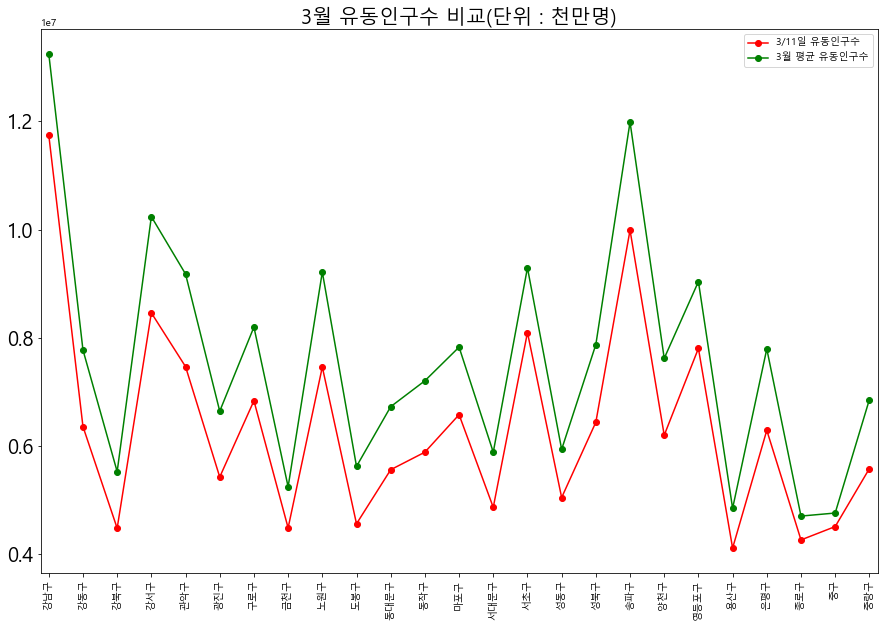

In [10]:
plot_y1 = sf_2003_outlier['3/11일 유동인구수'].iloc[0:-1]
plot_y2 = sf_2003_outlier['3월 평균 유동인구수'].iloc[0:-1]

plot_x1 = list(sf_2003_outlier.index)
plot_x1 = plot_x1[0:-1]

fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=20)
plt.margins(x=0.01)
plt.title("3월 유동인구수 비교(단위 : 천만명)", fontsize=20)

ax.plot(plot_x1, plot_y1, label = '3/11일 유동인구수', color='red', marker='o', linestyle = '-')
ax.plot(plot_x1, plot_y2, label = '3월 평균 유동인구수', color='green', marker='o', linestyle = '-')

plt.rc('font', family='Malgun Gothic')

plt.legend(loc='best')
plt.show()

In [11]:
# 이상치 데이터 세부 내용
# 송파구가 특별히 데이터 차이가 많이 났으므로 시간대별로 얼마나 차이가 났는지 Data Frame 작성
# 3/11일 송파구 데이터 작성
is_sf_songfa = sf_200311['군구'] == '송파구'

# 데이터 정렬
sf_songfa_03 = sf_200311[is_sf_songfa].sort_values(by=['시간(1시간단위)', '연령대(10세단위)', '성별'], axis=0, ascending=True)

# 3/11일을 제외한 송파구의 시간대별 유동인구수 체크
# sf_2003에서 송파구만 추출해서 DataFrame 저장
is_sf_2003_songfa = sf_2003[sf_2003['군구'] == '송파구' ]

# 3/11일을 제외하고 DataFrame 저장
sf_2003_songfa = is_sf_2003_songfa[is_sf_2003_songfa['일자'] != 20200311]

# 저장된 데이터를 나중에 합치기 위해 정렬
sf_2003_songfa = sf_2003_songfa.groupby(['시간(1시간단위)', '연령대(10세단위)', '성별'])[['유동인구수']].sum().sort_values(by=['시간(1시간단위)', '연령대(10세단위)', '성별'], axis=0, ascending=True)

# 유동인구수라는 열 이름이 겹칠 수 있으므로 열 이름 정리
sf_2003_songfa = sf_2003_songfa.rename(columns = {'유동인구수' : '3월 송파구 평균 유동인구수'})

# 데이터를 비교해야하므로 1일 평균 데이터 확보를 위해 30일로 나눔
sf_2003_songfa = sf_2003_songfa.apply(lambda x : x // 30)

# 별도의 시리즈로 분리(값만 빼서 Data Frame에 넣기 위해)
series_sf_2003_songfa = pd.Series(sf_2003_songfa['3월 송파구 평균 유동인구수'])

# 새로운 열을 만들고 거기에 방금 만든 평균 유동인구수 열을 합쳐준다
sf_songfa_03['3월 송파구 평균 유동인구수'] = series_sf_2003_songfa.values
sf_songfa_03 = sf_songfa_03.drop(['시', '군구'], axis=1)
sf_songfa_03 = sf_songfa_03.drop(['일자'], axis=1)

# 열 이름을 겹치지 않도록 수정
sf_songfa_03 = sf_songfa_03.rename(columns={'유동인구수' : '3/11일 송파구 유동인구수'})

# 차이와 차이비율 신규 열 작성
sf_songfa_03['차이(3/11 - 평균)'] = sf_songfa_03['3/11일 송파구 유동인구수'] - sf_songfa_03['3월 송파구 평균 유동인구수']
sf_songfa_03['(3/11 / 평균), %'] = sf_songfa_03['3/11일 송파구 유동인구수'] / sf_songfa_03['3월 송파구 평균 유동인구수'] * 100 - 100

# 인덱스를 새로 세팅하기 위해 index 숫자 작성해서 적용
idx_num = pd.Index(np.arange(288))
sf_songfa_03['index'] = idx_num
sf_songfa_03.set_index('index', inplace=True)

# 합계 행을 만들어서 각 열의 합계를 저장
songfa_sum = sf_songfa_03.sum(axis=0)
sf_songfa_03.loc['합계'] = songfa_sum

# 쓸데 없는 열은 빈칸을 입력
sf_songfa_03.loc['합계', '시간(1시간단위)'] = ''
sf_songfa_03.loc['합계', '연령대(10세단위)'] = ''
sf_songfa_03.loc['합계', '성별'] = ''

# 차이와 차이 비율은 합계가 아니라 각각의 열에 맞게 서식 수정
sf_songfa_03.loc['합계', '차이(3/11 - 평균)'] = sf_songfa_03.loc['합계', '3/11일 송파구 유동인구수'] - sf_songfa_03.loc['합계', '3월 송파구 평균 유동인구수'] 
sf_songfa_03.loc['합계', '(3/11 / 평균), %'] = sf_songfa_03.loc['합계', '3/11일 송파구 유동인구수'] / sf_songfa_03.loc['합계', '3월 송파구 평균 유동인구수'] *100 -100

# 1000 단위에서 쉼표로 구분하기 위해 apply 함수를 통해 쉼표 삽입
# sf_songfa_03['3/11일 송파구 유동인구수'] = sf_songfa_03.apply(lambda x : "{:,}".format(int(x['3/11일 송파구 유동인구수'])), axis=1)
# sf_songfa_03['3월 송파구 평균 유동인구수'] = sf_songfa_03.apply(lambda x : "{:,}".format(int(x['3월 송파구 평균 유동인구수'])), axis=1)
# sf_songfa_03['차이(3/11 - 평균)'] = sf_songfa_03.apply(lambda x : "{:,}".format(int(x['차이(3/11 - 평균)'])), axis=1)
# sf_songfa_03['(3/11 / 평균), %'] = sf_songfa_03.apply(lambda x : "{:.2f}".format(float(x['(3/11 / 평균), %'])), axis=1)


sf_songfa_03

,시간(1시간단위),연령대(10세단위),성별,3/11일 송파구 유동인구수,3월 송파구 평균 유동인구수,차이(3/11 - 평균),"(3/11 / 평균), %"
index,,,,,,,
0,0,20,남성,34080,41220,-7140,-17.321689
1,0,20,여성,35850,42920,-7070,-16.472507
2,0,30,남성,42770,52467,-9697,-18.482094
3,0,30,여성,45210,54412,-9202,-16.911711
4,0,40,남성,43520,52574,-9054,-17.221440
...,...,...,...,...,...,...,...
284,23,60,남성,27290,31275,-3985,-12.741807
285,23,60,여성,28410,32367,-3957,-12.225415
286,23,70,남성,14240,16560,-2320,-14.009662


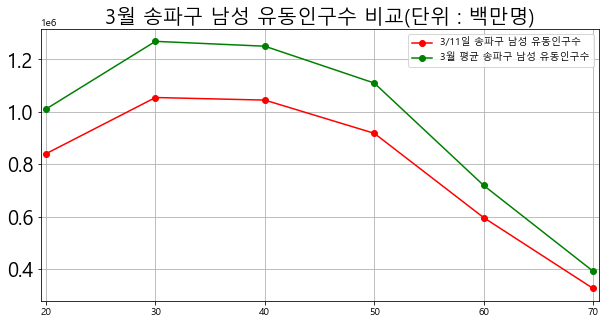

In [12]:
men_sf_songfa = sf_songfa_03[sf_songfa_03['성별'] == '남성']
men_sf_songfa = men_sf_songfa.groupby(['연령대(10세단위)'])[['3/11일 송파구 유동인구수', '3월 송파구 평균 유동인구수']].sum()

plot_x1 = men_sf_songfa.index
plot_y1 = men_sf_songfa['3/11일 송파구 유동인구수']
plot_y2 = men_sf_songfa['3월 송파구 평균 유동인구수']

fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation = 0, fontsize=10)
plt.yticks(fontsize=20)
plt.margins(x=0.01)
plt.title("3월 송파구 남성 유동인구수 비교(단위 : 백만명)", fontsize=20)

ax.plot(plot_x1, plot_y1, label = '3/11일 송파구 남성 유동인구수', color='red', marker='o', linestyle = '-')
ax.plot(plot_x1, plot_y2, label = '3월 평균 송파구 남성 유동인구수', color='green', marker='o', linestyle = '-')

plt.rc('font', family='Malgun Gothic')

plt.grid(True)
plt.legend(loc='best')
plt.show()

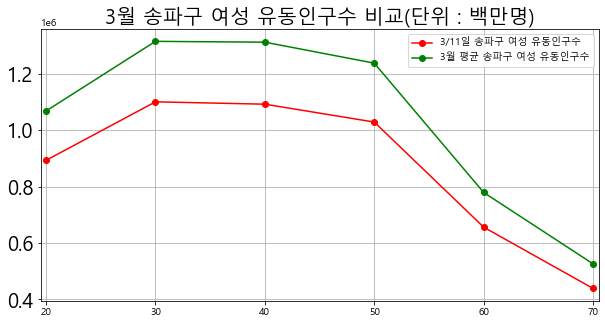

In [13]:
women_sf_songfa = sf_songfa_03[sf_songfa['성별'] == '여성']
women_sf_songfa = women_sf_songfa.groupby(['연령대(10세단위)'])[['3/11일 송파구 유동인구수', '3월 송파구 평균 유동인구수']].sum()


plot_x1 = women_sf_songfa.index
plot_y1 = women_sf_songfa['3/11일 송파구 유동인구수']
plot_y2 = women_sf_songfa['3월 송파구 평균 유동인구수']

fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation = 0, fontsize=10)
plt.yticks(fontsize=20)
plt.margins(x=0.01)
plt.title("3월 송파구 여성 유동인구수 비교(단위 : 백만명)", fontsize=20)

ax.plot(plot_x1, plot_y1, label = '3/11일 송파구 여성 유동인구수', color='red', marker='o', linestyle = '-')
ax.plot(plot_x1, plot_y2, label = '3월 평균 송파구 여성 유동인구수', color='green', marker='o', linestyle = '-')

plt.rc('font', family='Malgun Gothic')

plt.grid(True)
plt.legend(loc='best')
plt.show()

In [14]:
# 5/29일과 5월 평균치 비교
# 5/29일 각 구별 유동인구수 Dataframe으로 만들기
is_sf_200529 = sf_2005['일자'] == 20200529
sf_200529 = sf_2005[is_sf_200529]

sf_200529_floating = sf_200529.groupby(['군구'])[['유동인구수']].sum().sort_values(by=['군구'], axis=0, ascending=True)
sf_200529_floating = sf_200529_floating.rename(columns={'유동인구수' : '5/29일 유동인구수'})

# ------------------------------------------------------------------------------------------------------------
# 3/11일을 제외한 나머지 일자의 유동인구수 평균 Dataframe으로 만들기
sf_2005_mean = sf_2005[sf_2005['일자'] != 20200529]
sf_2005_mean = sf_2005_mean.groupby(['군구'])[['유동인구수']].sum().sort_values(by=['군구'], axis=0, ascending=True)
sf_2005_mean = sf_2005_mean.rename(columns={'유동인구수' : '5월 평균 유동인구수'})

sf_2005_mean['5월 평균 유동인구수'] = sf_2005_mean.apply(lambda x : x//30)

# -----------------------------------------------------------------------------------------------------------------------
# 5/29일 유동인구수와 나머지 일자의 DataFrame 합치기
sf_2005_outlier = pd.concat([sf_200529_floating, sf_2005_mean], axis=1)

# 타입을 int로 변경하기
sf_2005_outlier.astype({'5/29일 유동인구수':'int', '5월 평균 유동인구수':'int'}).dtypes

# 유동인구수 차이 인구수를 구해서 신규 열 만들기
sf_2005_outlier['차이(5/29 - 평균)'] = sf_2005_outlier['5/29일 유동인구수'] - sf_2005_outlier['5월 평균 유동인구수']

# 유동인구수 차이를 %로 표현하고 신규 열 만들기
sf_2005_outlier['(5/29 / 평균), %'] = (sf_2005_outlier['5/29일 유동인구수'] / sf_2005_outlier['5월 평균 유동인구수'] * 100 - 100)

# 열별 합계값을 col_sum 변수에 넣은 다음 합계라는 신규 행을 만들어 입력한다
col_sum = sf_2005_outlier.sum(axis=0)
sf_2005_outlier.loc['합 계'] = col_sum

sf_2005_outlier.loc['합 계', '차이(5/29 - 평균)'] = sf_2005_outlier.loc['합 계', '5/29일 유동인구수'] - sf_2005_outlier.loc['합 계', '5월 평균 유동인구수'] 
sf_2005_outlier.loc['합 계', '(5/29 / 평균), %'] = sf_2005_outlier.loc['합 계', '5/29일 유동인구수'] / sf_2005_outlier.loc['합 계', '5월 평균 유동인구수'] *100 -100


# 평균을 int type으로 변경 -> 소수점을 표기해야하므로 주석처리(09. 07)
# sf_2003_outlier.astype({'(3/11 / 평균), %':'int'}).dtypes

# 각각의 표기법을 1,000단위에서 쉼표로 구분해주고, %는 소수점 둘째자리까지 표기
# sf_2005_outlier['5/29일 유동인구수'] = sf_2005_outlier.apply(lambda x : "{:,}".format(int(x['5/29일 유동인구수'])), axis=1)
# sf_2005_outlier['5월 평균 유동인구수'] = sf_2005_outlier.apply(lambda x : "{:,}".format(int(x['5월 평균 유동인구수'])), axis=1)
# sf_2005_outlier['차이(5/29 - 평균)'] = sf_2005_outlier.apply(lambda x : "{:,}".format(int(x['차이(5/29 - 평균)'])), axis=1)
# sf_2005_outlier['(5/29 / 평균), %'] = sf_2005_outlier.apply(lambda x : "{:.2f}".format(float(x['(5/29 / 평균), %'])), axis=1)


sf_2005_outlier

,5/29일 유동인구수,5월 평균 유동인구수,차이(5/29 - 평균),"(5/29 / 평균), %"
군구,,,,
강남구,11007760.0,13754208.0,-2746448.0,-19.968056
강동구,5472280.0,7917247.0,-2444967.0,-30.881530
강북구,3831210.0,5676263.0,-1845053.0,-32.504713
강서구,7366570.0,10485111.0,-3118541.0,-29.742565
관악구,6417790.0,9450387.0,-3032597.0,-32.089659
광진구,4646700.0,6808037.0,-2161337.0,-31.746846
구로구,5973500.0,8395937.0,-2422437.0,-28.852491
금천구,4060480.0,5322875.0,-1262395.0,-23.716413
노원구,6458910.0,9511693.0,-3052783.0,-32.095054


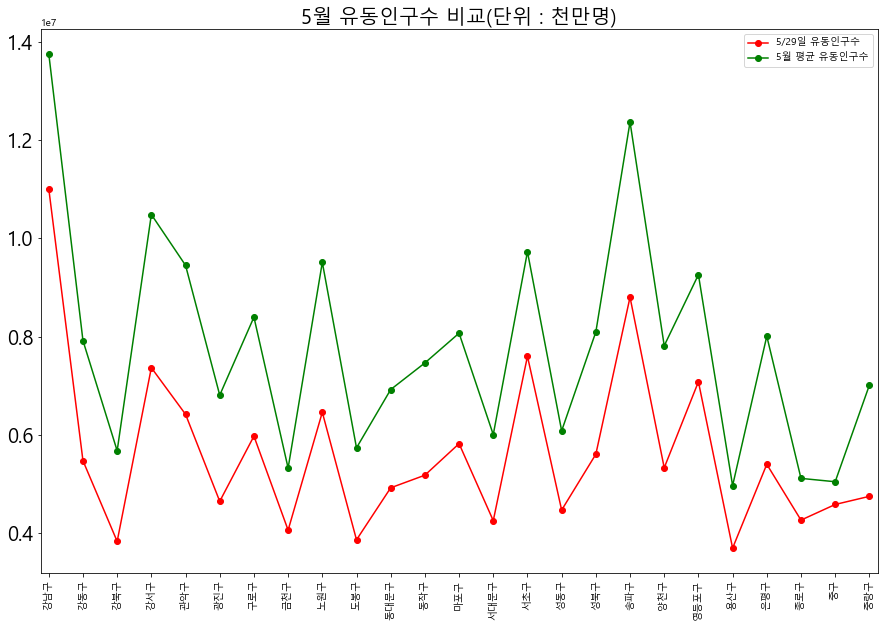

In [15]:
plot_y1 = sf_2005_outlier['5/29일 유동인구수'].iloc[0:-1]
plot_y2 = sf_2005_outlier['5월 평균 유동인구수'].iloc[0:-1]

plot_x1 = list(sf_2005_outlier.index)
plot_x1 = plot_x1[0:-1]

fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=20)
plt.margins(x=0.01)
plt.title("5월 유동인구수 비교(단위 : 천만명)", fontsize=20)

ax.plot(plot_x1, plot_y1, label = '5/29일 유동인구수', color='red', marker='o', linestyle = '-')
ax.plot(plot_x1, plot_y2, label = '5월 평균 유동인구수', color='green', marker='o', linestyle = '-')

plt.rc('font', family='Malgun Gothic')

plt.legend(loc='best')
plt.show()

In [16]:
test_a = sf_2005[sf_2005['군구'] == '은평구']
test_b = test_a[test_a['일자'] == 20200529]
test_b = test_b.sort_values(['시간(1시간단위)', '연령대(10세단위)'], axis=0, ascending=True)
print(test_b)

              일자  시간(1시간단위)  연령대(10세단위)  성별   시   군구  유동인구수
15910   20200529          0          20  남성  서울  은평구  28550
160537  20200529          0          20  여성  서울  은평구  30310
19916   20200529          0          30  남성  서울  은평구  36520
208528  20200529          0          30  여성  서울  은평구  37550
76183   20200529          0          40  남성  서울  은평구  37920
...          ...        ...         ...  ..  ..  ...    ...
216667  20200529         16          50  여성  서울  은평구  31610
7813    20200529         16          60  남성  서울  은평구  16980
24063   20200529         16          60  여성  서울  은평구  23420
26118   20200529         16          70  여성  서울  은평구  22720
184653  20200529         16          70  남성  서울  은평구  15360

[204 rows x 7 columns]


In [17]:
test_a = sf_2005[sf_2005['군구'] == '도봉구']
test_b = test_a[test_a['일자'] == 20200529]
test_b = test_b.sort_values(['시간(1시간단위)', '연령대(10세단위)'], axis=0, ascending=True)
print(test_b)

              일자  시간(1시간단위)  연령대(10세단위)  성별   시   군구  유동인구수
66047   20200529          0          20  여성  서울  도봉구  21850
116065  20200529          0          20  남성  서울  도봉구  20940
150390  20200529          0          30  여성  서울  도봉구  22620
184603  20200529          0          30  남성  서울  도봉구  22520
24016   20200529          0          40  여성  서울  도봉구  27910
...          ...        ...         ...  ..  ..  ...    ...
208568  20200529         16          50  여성  서울  도봉구  24190
98126   20200529         16          60  남성  서울  도봉구  13330
126188  20200529         16          60  여성  서울  도봉구  16630
13972   20200529         16          70  남성  서울  도봉구  11570
214611  20200529         16          70  여성  서울  도봉구  16700

[204 rows x 7 columns]


In [18]:
test_a = sf_2005[sf_2005['군구'] == '광진구']
test_b = test_a[test_a['일자'] == 20200529]
test_b = test_b.sort_values(['시간(1시간단위)', '연령대(10세단위)'], axis=0, ascending=True)
print(test_b)

              일자  시간(1시간단위)  연령대(10세단위)  성별   시   군구  유동인구수
126146  20200529          0          20  여성  서울  광진구  33610
136166  20200529          0          20  남성  서울  광진구  32190
13918   20200529          0          30  남성  서울  광진구  30900
55929   20200529          0          30  여성  서울  광진구  30960
5751    20200529          0          40  여성  서울  광진구  30010
...          ...        ...         ...  ..  ..  ...    ...
9882    20200529         16          50  남성  서울  광진구  22520
80141   20200529         16          60  여성  서울  광진구  16970
122135  20200529         16          60  남성  서울  광진구  14680
128162  20200529         16          70  남성  서울  광진구   9770
140293  20200529         16          70  여성  서울  광진구  13420

[204 rows x 7 columns]


In [19]:
test_a = sf_2005[sf_2005['군구'] == '강남구']
test_b = test_a[test_a['일자'] == 20200529]
test_b = test_b.sort_values(['시간(1시간단위)', '연령대(10세단위)'], axis=0, ascending=True)
print(test_b)

              일자  시간(1시간단위)  연령대(10세단위)  성별   시   군구  유동인구수
21934   20200529          0          20  남성  서울  강남구  38670
53825   20200529          0          20  여성  서울  강남구  42000
36006   20200529          0          30  남성  서울  강남구  50030
160538  20200529          0          30  여성  서울  강남구  52700
62043   20200529          0          40  여성  서울  강남구  52950
...          ...        ...         ...  ..  ..  ...    ...
200567  20200529         16          50  남성  서울  강남구  64160
9883    20200529         16          60  남성  서울  강남구  32300
9884    20200529         16          60  여성  서울  강남구  34480
30061   20200529         16          70  여성  서울  강남구  22050
142380  20200529         16          70  남성  서울  강남구  17850

[204 rows x 7 columns]


# 1. 일별확진자수 - 김현정

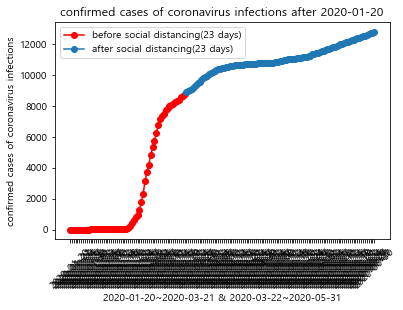

In [20]:
#사회적 거리두기 시행 전/후의 일별 확진자수를 시각화합니다.
date_corona= time['date'] #날짜 column
conNum= time['confirmed'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize']= [15,10] # [width, height]

#그래프 그리기
xbefore=date_corona[:62] #1월 20일~ 3월 21일을 x축으로 지정
ybefore=conNum[:62] #1월 20일~ 3월 21일의 확진자수를 y축으로 지정
plt.plot(xbefore, ybefore, marker='o', color='r', label='before social distancing(23 days)')

#사회적 거리두기 이후의 확진자수 그래프 그리기
xafter=date_corona[62:len(date_corona)] #사회적 거리두기 시작일인 3월 22일부터를 x축으로 지정
yafter=conNum[62:len(conNum)] # 3월 22일~ 5월 31일의 확진자수를 y축으로 지정
plt.plot(xafter, yafter, marker='o', label='after social distancing(23 days)')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.xlabel("2020-01-20~2020-03-21 & 2020-03-22~2020-05-31")
plt.ylabel("confirmed cases of coronavirus infections")
plt.title("confirmed cases of coronavirus infections after 2020-01-20")
plt.legend()
plt.show()

# 2. 날짜별 유동인구의 변화 - 양문영

In [21]:
# Windows 한글
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [22]:
time = time[['date', 'time', 'test', 'negative', 'confirmed']]
time.head()

,date,time,test,negative,confirmed
0,2020-01-20,16,1,0,1
1,2020-01-21,16,1,0,1
2,2020-01-22,16,4,3,1
3,2020-01-23,16,22,21,1
4,2020-01-24,16,27,25,2


In [23]:
# test 대비 확진자 수
print(time.count())
print(len(time['date'].unique())) # => row에 중복되는 날짜가 없음을 알 수 있다.

test_divide = time[['date', 'test', 'negative', 'confirmed']]
test_divide['confirmed/test (단위 %)']  = round((test_divide['confirmed'] / test_divide['test']) * 100, 1)
test_divide['negative/test (단위 %)']  = round((test_divide['negative'] / test_divide['test']) * 100, 1)

# test 진행 횟수가 적으면 조금만 증가하여도 %가 많이 차이나기 때문에 test 횟수가 100이상인 데이터만 확인함.
test_divide = test_divide[test_divide['test'] >= 100]
test_divide

date         163
time         163
test         163
negative     163
confirmed    163
dtype: int64
163


,date,test,negative,confirmed,confirmed/test (단위 %),negative/test (단위 %)
8,2020-01-28,116,97,4,3.4,83.6
9,2020-01-29,187,155,4,2.1,82.9
10,2020-01-30,246,199,6,2.4,80.9
11,2020-01-31,312,245,11,3.5,78.5
12,2020-02-01,371,289,12,3.2,77.9
...,...,...,...,...,...,...
158,2020-06-26,1232315,1200885,12602,1.0,97.4
159,2020-06-27,1243780,1211261,12653,1.0,97.4
160,2020-06-28,1251695,1219975,12715,1.0,97.5
161,2020-06-29,1259954,1228698,12757,1.0,97.5


In [24]:
_0229 = test_divide[test_divide['date'] <= '2020-02-29']
_0229_0419 = test_divide[('2020-02-29' <= test_divide['date']) & (test_divide['date'] <= '2020-04-19')]
_0419_ = test_divide['2020-04-19' <= test_divide['date']]
_0229

,date,test,negative,confirmed,confirmed/test (단위 %),negative/test (단위 %)
8,2020-01-28,116,97,4,3.4,83.6
9,2020-01-29,187,155,4,2.1,82.9
10,2020-01-30,246,199,6,2.4,80.9
11,2020-01-31,312,245,11,3.5,78.5
12,2020-02-01,371,289,12,3.2,77.9
13,2020-02-02,429,327,15,3.5,76.2
14,2020-02-03,490,414,15,3.1,84.5
15,2020-02-04,607,462,16,2.6,76.1
16,2020-02-05,714,522,18,2.5,73.1
17,2020-02-06,885,693,23,2.6,78.3


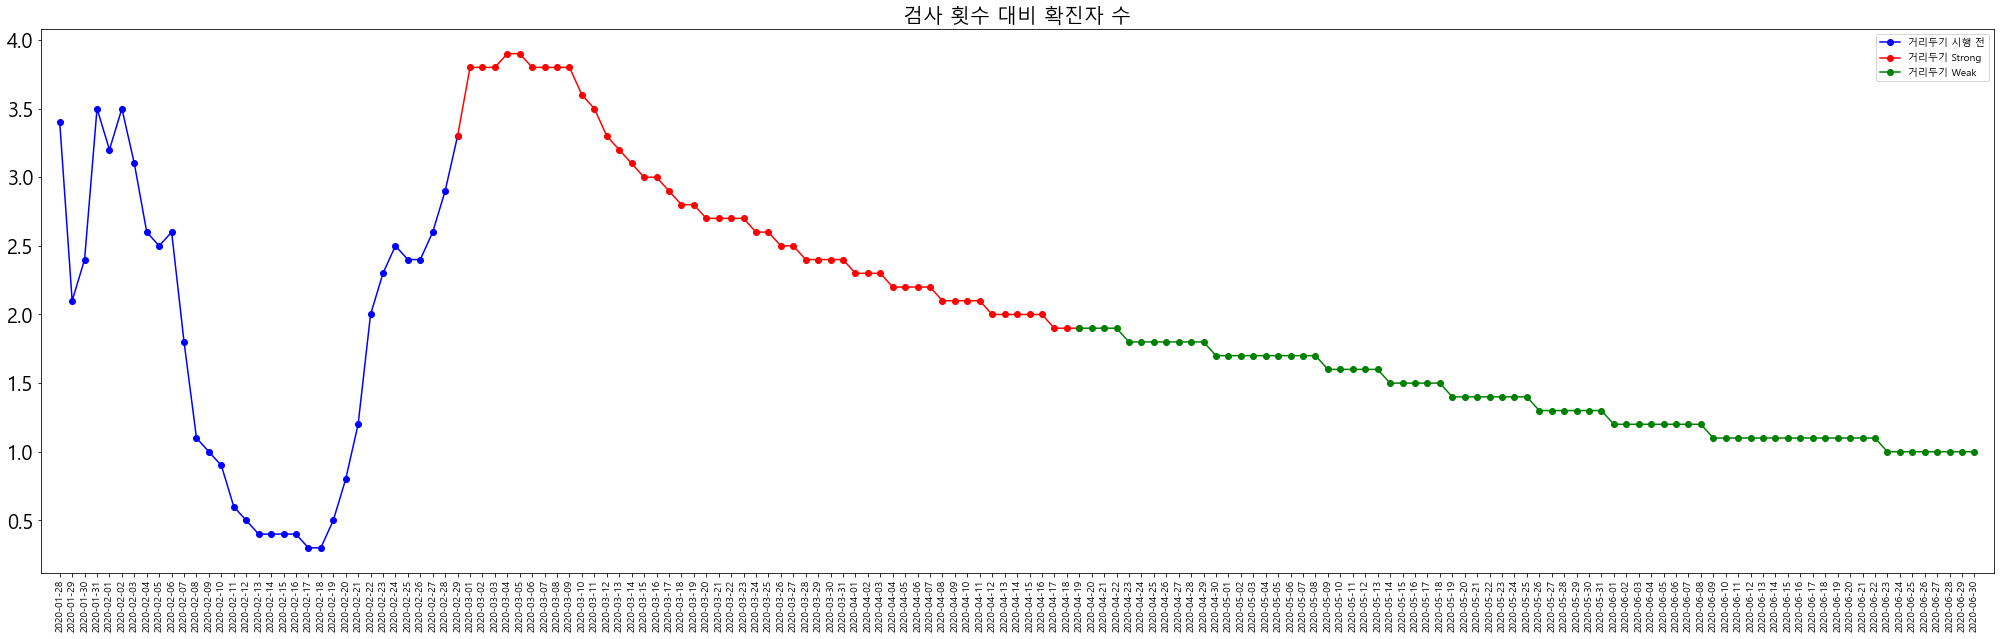

In [25]:
fig, ax = plt.subplots(figsize=(35,10))
plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=20)
plt.margins(x=0.01)
plt.title("검사 횟수 대비 확진자 수", fontsize=20)

ax.plot(_0229['date'], _0229[['confirmed/test (단위 %)']], marker='o', c='b', label='거리두기 시행 전')
ax.plot(_0229_0419['date'], _0229_0419[['confirmed/test (단위 %)']], marker='o', c='r', label='거리두기 Strong')
ax.plot(_0419_['date'], _0419_[['confirmed/test (단위 %)']], marker='o', c='g', label='거리두기 Weak')

plt.legend()
plt.show()

In [26]:
# 그래프를 해석하기 위해 날짜별로 infection_case를 group하여 출력하였다.
time_patient = pd.merge(test_divide, patient_info, left_on='date', right_on='confirmed_date')[['date', 'test', 'negative', 'confirmed', 'infection_case']]
time_patient = time_patient.groupby(['date', 'infection_case']).max()  # -> ['test', 'negative', 'confirmed'] columns가 누적 횟수이기 때문에 같은 그룹 중 가장 큰 값을 표시하도록 함.
time_patient.loc[:'2020-02-17']

test  negative  confirmed
date       infection_case                                 
2020-01-30 contact with patient   246       199          6
           overseas inflow        246       199          6
2020-01-31 contact with patient   312       245         11
2020-02-01 contact with patient   371       289         12
2020-02-02 contact with patient   429       327         15
           overseas inflow        429       327         15
2020-02-03 overseas inflow        490       414         15
2020-02-05 contact with patient   714       522         18
           overseas inflow        714       522         18
2020-02-06 contact with patient   885       693         23
           overseas inflow        885       693         23
2020-02-07 overseas inflow       1352      1001         24
2020-02-09 contact with patient  2598      1683         27
           overseas inflow       2598      1683         27
2020-02-10 contact with patient  3110      2552         27
2020-02-16 contact with patient  8161      7647         29

In [27]:
time_patient.loc['2020-02-18':'2020-02-29']

test  negative  confirmed
date       infection_case                                           
2020-02-18 Shincheonji Church              9772      8923         31
           contact with patient            9772      8923         31
           etc                             9772      8923         31
2020-02-19 Cheongdo Daenam Hospital       11173      9973         51
           Seongdong-gu APT               11173      9973         51
           Shincheonji Church             11173      9973         51
           contact with patient           11173      9973         51
           etc                            11173      9973         51
2020-02-20 Cheongdo Daenam Hospital       13202     11238        104
           Seongdong-gu APT               13202     11238        104
           Shincheonji Church             13202     11238        104
           contact with patient           13202     11238        104
           etc                            13202     11238        104
2020-02-21 Cheongdo Daenam Hospital       16400     13016        204
           Eunpyeong St. Mary's Hospital  16400     13016        204
           Onchun Church                  16400     13016        204
           Pilgrimage to Israel           16400     13016        204
           Shincheonji Church             16400     13016        204
           contact with patient           16400     13016        204
           etc                            16400     13016        204
2020-02-22 Cheongdo Daenam Hospital       21586     15116        433
           Eunpyeong St. Mary's Hospital  21586     15116        433
           Onchun Church                  21586     15116        433
           Shincheonji Church             21586     15116        433
           contact with patient           21586     15116        433
           etc                            21586     15116        433
           overseas inflow                21586     15116        433
2020-02-23 Cheongdo Daenam Hospital       26179     17520        602
           Eunpyeong St. Mary's Hospital  26179     17520        602
           Onchun Church                  26179     17520        602
           Shincheonji Church             26179     17520        602
           contact with patient           26179     17520        602
           etc                            26179     17520        602
           overseas inflow                26179     17520        602
2020-02-24 Milal Shelter                  32756     20292        833
           Onchun Church                  32756     20292        833
           Pilgrimage to Israel           32756     20292        833
           Shincheonji Church             32756     20292        833
           contact with patient           32756     20292        833
           etc                            32756     20292        833
2020-02-25 Cheongdo Daenam Hospital       40304     25447        977
           Eunpyeong St. Mary's Hospital  40304     25447        977
           Milal Shelter                  40304     25447        977
           Onchun Church                  40304     25447        977
           Seongdong-gu APT               40304     25447        977
           Shincheonji Church             40304     25447        977
           contact with patient           40304     25447        977
           etc                            40304     25447        977
           gym facility in Cheonan        40304     25447        977
           overseas inflow                40304     25447        977
2020-02-26 Cheongdo Daenam Hospital       53553     31576       1261
           Eunpyeong St. Mary's Hospital  53553     31576       1261
           Onchun Church                  53553     31576       1261
           Shincheonji Church             53553     31576       1261
           contact with patient           53553     31576       1261
           etc                            53553     31576       1261
           gym facility in Cheonan       

In [28]:
time_patient.loc['2020-02-29':'2020-03-09']

test  negative  confirmed
date       infection_case                                                    
2020-02-29 Shincheonji Church                      94055     55723       3150
           Suyeong-gu Kindergarten                 94055     55723       3150
           contact with patient                    94055     55723       3150
           etc                                     94055     55723       3150
           gym facility in Cheonan                 94055     55723       3150
           overseas inflow                         94055     55723       3150
2020-03-01 Gyeongsan Seorin Nursing Home           98921     61825       3736
           Seongdong-gu APT                        98921     61825       3736
           Shincheonji Church                      98921     61825       3736
           contact with patient                    98921     61825       3736
           etc                                     98921     61825       3736
           gym facility in Cheonan                 98921     61825       3736
           overseas inflow                         98921     61825       3736
2020-03-02 Gyeongsan Seorin Nursing Home          109591     71580       4212
           Onchun Church                          109591     71580       4212
           Seongdong-gu APT                       109591     71580       4212
           Shincheonji Church                     109591     71580       4212
           contact with patient                   109591     71580       4212
           etc                                    109591     71580       4212
2020-03-03 Milal Shelter                          125851     85484       4812
           Shincheonji Church                     125851     85484       4812
           contact with patient                   125851     85484       4812
           etc                                    125851     85484       4812
2020-03-04 Bonghwa Pureun Nursing Home            136707    102965       5328
           Changnyeong Coin Karaoke               136707    102965       5328
           Dongan Church                          136707    102965       5328
           Seongdong-gu APT                       136707    102965       5328
           Shincheonji Church                     136707    102965       5328
           contact with patient                   136707    102965       5328
           etc                                    136707    102965       5328
           overseas inflow                        136707    102965       5328
2020-03-05 Bonghwa Pureun Nursing Home            146541    118965       5766
           Changnyeong Coin Karaoke               146541    118965       5766
           Gyeongsan Cham Joeun Community Center  146541    118965       5766
           Gyeongsan Jeil Silver Town             146541    118965       5766
           Shincheonji Church                     146541    118965       5766
           contact with patient                   146541    118965       5766
           etc                                    146541    118965       5766
2020-03-06 Dongan Church                          164740    136624       6284
           Gyeongsan Cham Joeun Community Center  164740    136624       6284
           Gyeongsan Jeil Silver Town             164740    136624       6284
           contact with patient                   164740    136624       6284
           etc                                    164740    136624       6284
           gym facility in Cheonan                164740    136624       6284
2020-03-07 Gyeongsan Cham Joeun Community Center  178189    151802       6767
           Gyeongsan Jeil Silver Town             178189    151802       6767
           Onchun Church                          178189    151802       6767
           contact with patient                   178189    151802       6767
           etc                                    178189    151802       6767
           gym facility in Sejong                 178189    151802       6

#### 그래프 해석
- 초기의 감염원인은 대부분 해외 유입으로 인한 감염과 그 확진자와 접촉한 사람들이 확진되는 경우이었다.
- test 대비 확진자 수가 증가하기 시작한 것은 신천지 집단 감염이 시작되는 2/18부터 이다.
- 이후 신천지 뿐만 아니라 여러 곳에서 집단 감염이 시작되었고, 이로 인해 확진자 수가 계속 증가하였다.
- 2/29부터 사회적 거리두기가 시작되었고(빨강), 이전 집단 감염으로 인한 확진자 수가 증가하다가 확진자 수가 줄어드는 추세를 확인할 수 있다.

In [29]:
policy[policy['gov_policy'] == 'Social Distancing Campaign']

,policy_id,country,type,gov_policy,detail,start_date,end_date
28,29,Korea,Social,Social Distancing Campaign,Strong,2020-02-29,2020-03-21
29,30,Korea,Social,Social Distancing Campaign,Strong,2020-03-22,2020-04-19
30,31,Korea,Social,Social Distancing Campaign,Weak,2020-04-20,2020-05-05
31,32,Korea,Social,Social Distancing Campaign,Weak(1st),2020-05-06,NaN


In [30]:
date_seoul = seoulfloating['date'].unique().tolist()
len(date_seoul)

151

In [31]:
pv = pd.pivot_table(index='date', data=seoulfloating, values='fp_num', aggfunc='sum')
print(pv['fp_num'].min(), pv['fp_num'].max())
print(pv.index.min(), pv.index.max())
pv.T

140847320 373087550
2020-01-01 2020-05-31


date,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,...,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31
fp_num,192406170,202929360,203337150,197396050,195747670,204352220,204132390,204140970,203820070,203576150,...,198994440,190649680,189785600,199383610,199347850,199293080,199209840,140847320,189674150,188346500


## 전체 날짜별 유동인구의 변화

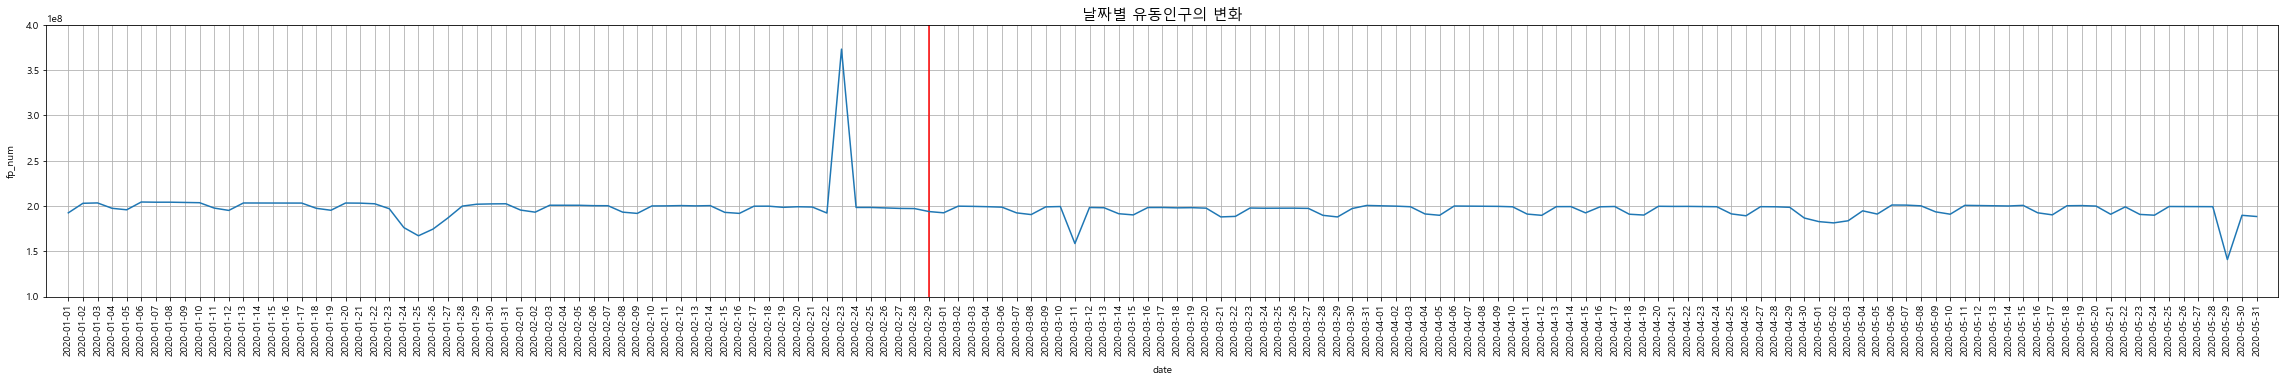

In [32]:
# 통합
fig, ax = plt.subplots(figsize=(40,5))
plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=10)
plt.title("날짜별 유동인구의 변화", fontsize=15)
plt.grid(True)
plt.ylim(10**8, 4*10**8)
plt.margins(x=0.01)

ax.set_xlabel('date', labelpad=10)
ax.set_ylabel('fp_num', labelpad=10)
ax.plot(pv)
plt.vlines(x='2020-02-29', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.show()

In [33]:
def drawGraph(figSize, drawWhat):
    fig, ax = plt.subplots(figsize=figSize)
    plt.xticks(rotation = 90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("날짜별 유동인구의 변화", fontsize=15)
    plt.grid(True)
    plt.ylim(10**8, 4*10**8)
    plt.margins(x=0.01)

    ax.set_xlabel('date', labelpad=10)
    ax.set_ylabel('fp_num', labelpad=10)
    ax.plot(drawWhat)
    plt.show()

## 사회적 거리두기 실행 전 유동인구의 변화
- ~ 2/28

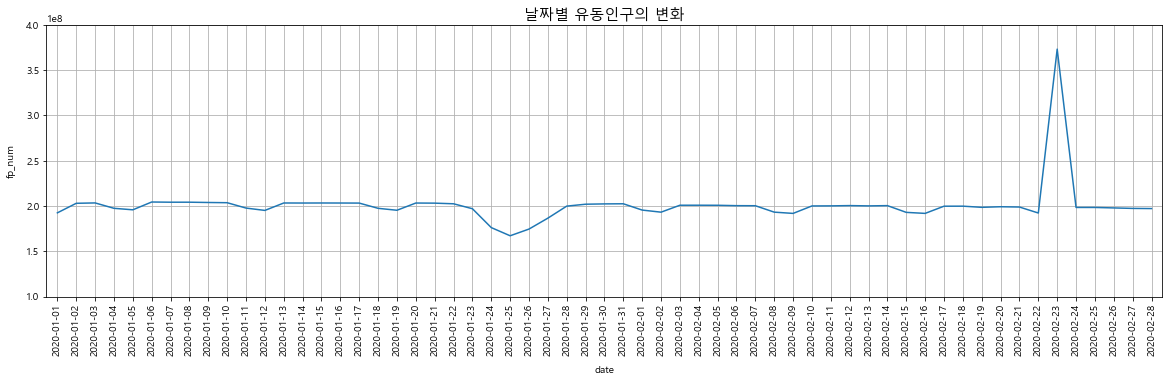

In [34]:
# 1/1 ~ 2/28
drawGraph((20,5), pv[pv.index <= '2020-02-28'])

## 사회적 거리두기(Strong) 실행
- 2/29 ~ 4/19

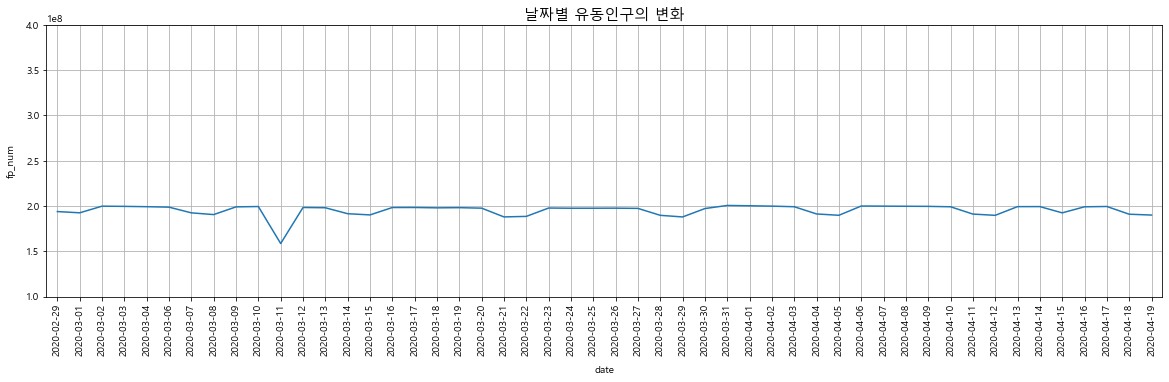

In [35]:
# 2/29 ~ 4/19
drawGraph((20,5), pv[('2020-02-29' <= pv.index) & (pv.index <= '2020-04-19')])

## 사회적 거리두기(Weak) 실행
- 4/20 ~

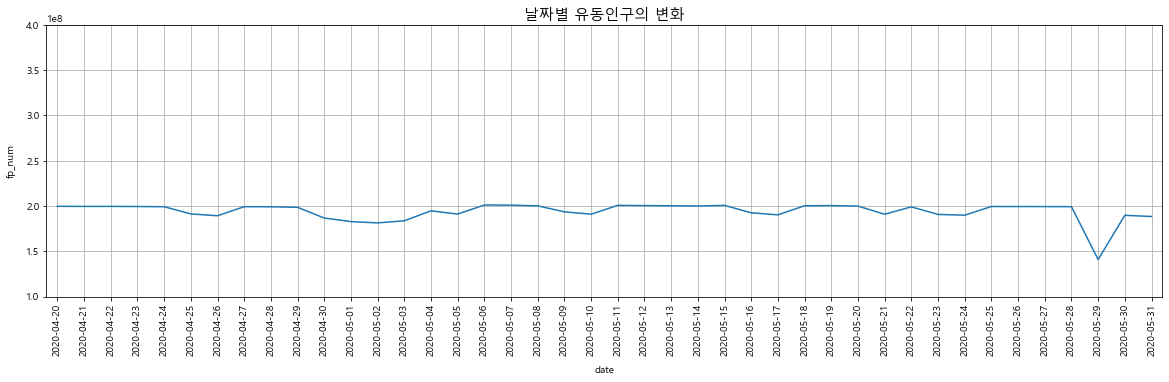

In [36]:
# 4/20 ~
drawGraph((20,5), pv['2020-04-20' <= pv.index])

# 3. 사회적 거리 두기 이전, 이후의 확진율, 유동성 - 정현우

### 3.1 확진율 비교

### 3.1.1 사회적 거리두기 이전의 확진율

----

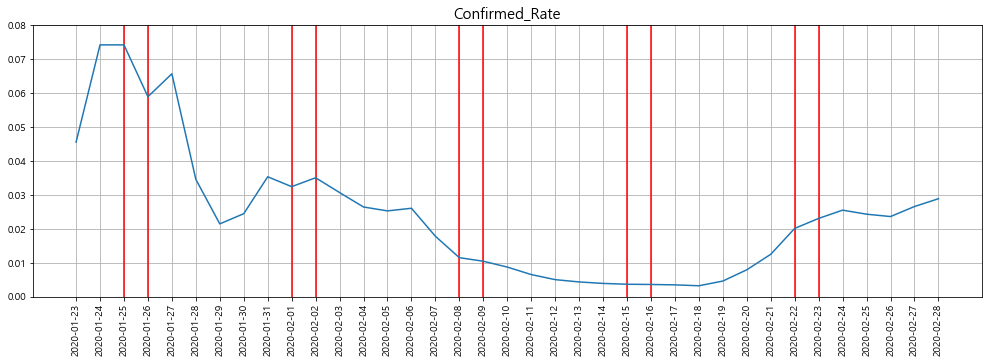

In [37]:
from datetime import date

df = pd.read_csv(r'./data/SeoulFloating.csv')
patient_info = pd.read_csv(r"./data/PatientInfo.csv")
time = pd.read_csv(r'./data/Time.csv')
#dataFrame에서 date, fp_num 행 남겨둠. 
df = df.drop(['hour','sex', 'birth_year', 'province','city'], axis = 1)
#확진률 알아보기

x = pv.index
y = pv['fp_num']

new_confirmed = time['confirmed']
new_test = time['test']
#날짜
confirmed_date=time['date']

weekend = []

sat = date(2020, 1, 4)
while str(sat) <= '2020-05-30' :
    weekend.append(str(sat))
    weekend.append(str(sat+timedelta(days=1)))
    sat = sat + timedelta(days=7)


# ---------------------------------------------------------------------------------------------------------------#
confirmed_date_0 = confirmed_date[3:40]
#confirmed_date = confirmed_date.values

confirmed_rate_0 = new_confirmed[3:40]/new_test[3:40]   # 확진률의 경향성을 보기 위해 변화가 미미한 부분은 제외
#cpnfirmed_date = confirmed_date.values
#confirmed_rate3 = np.append(confirmed_rate,confirmed_rate2)


fig, ax = plt.subplots(figsize=(17,5))
plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 0.08)
plt.grid(True)
plt.title("Confirmed_Rate", fontsize=15)
plt.plot(confirmed_date_0, confirmed_rate_0)

plt.vlines(x='2020-01-25', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-01-26', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-02-01', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-02-02', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-02-08', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-02-09', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-02-15', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-02-16', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-02-22', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-02-23', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.show()


#for i in range(84) :
#  confirmed_rate[1] = 
#  confirmed_rate[i+1] = (new_confirmed[i+1]-new_confirmed[i])/(new_test[i+1]-new_test[i])

### 3.1.2. 강도 높은 사회적 거리두기(strong) 시행 이후의 확진율 (20. 02. 29 ~ 20. 04. 16)


------------------------------------------------------------------------------------------------------------------

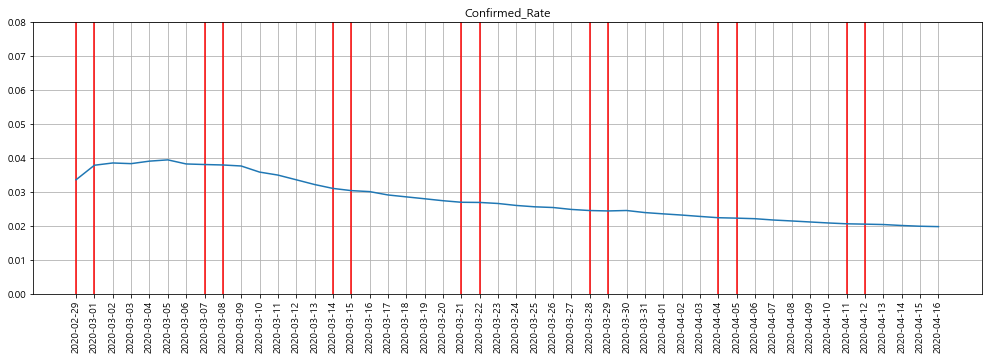

In [38]:
confirmed_date_1 = confirmed_date[40:88]
#confirmed_date = confirmed_date.values

confirmed_rate_1 = new_confirmed[40:88]/new_test[40:88]   # 확진률의 경향성을 보기 위해 변화가 미미한 부분은 제외
#cpnfirmed_date = confirmed_date.values
#confirmed_rate3 = np.append(confirmed_rate,confirmed_rate2)
plt.figure(figsize=(17,5))
plt.ylim(0, 0.08)
plt.grid(True)
plt.title("Confirmed_Rate")
plt.xticks(rotation = 90)
plt.plot(confirmed_date_1, confirmed_rate_1)

plt.vlines(x='2020-02-29', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-01', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-03-07', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-08', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-03-14', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-15', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-03-21', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-22', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-03-28', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-29', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-04-04', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-04-05', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-04-11', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-04-12', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.show()

### 3.1.3. 약한 사회적 거리두기(weak) 시행 이후의 확진율(20. 04. 17 ~)

------------------------------------------------------------------------------------------------------------------

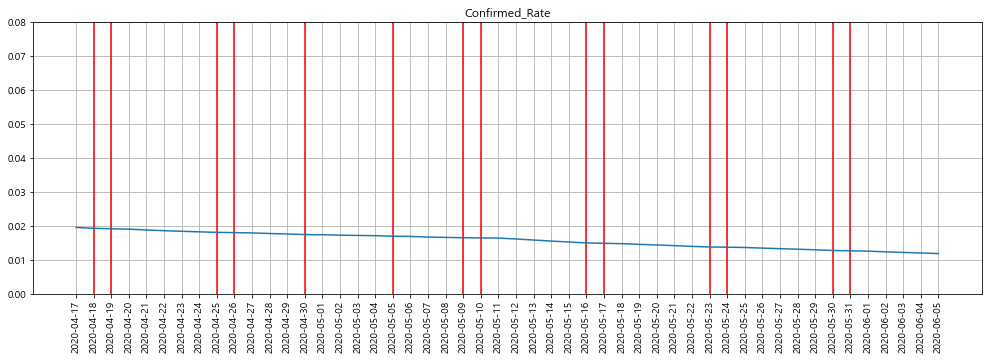

In [39]:
confirmed_date_2 = confirmed_date[88:138]
#confirmed_date = confirmed_date.values

confirmed_rate_2 = new_confirmed[88:138]/new_test[88:138]   # 확진률의 경향성을 보기 위해 변화가 미미한 부분은 제외
#cpnfirmed_date = confirmed_date.values
#confirmed_rate3 = np.append(confirmed_rate,confirmed_rate2)
plt.figure(figsize=(17,5))
plt.ylim(0, 0.08)
plt.grid(True)
plt.title("Confirmed_Rate")
plt.xticks(rotation = 90)
plt.plot(confirmed_date_2, confirmed_rate_2)

plt.vlines(x='2020-04-18', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-04-19', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-04-25', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-04-26', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-04-30', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-05', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-05-09', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-10', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-05-16', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-17', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-05-23', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-24', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-05-30', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-31', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.show()

### 3.2. 사회적 거리두기 이전, 이후의 유동성

### 3.2.1. 사회적 거리두기 이전의 유동성( ~ 20.2.28)

------------------------------------------------------------------------------------------------------------------

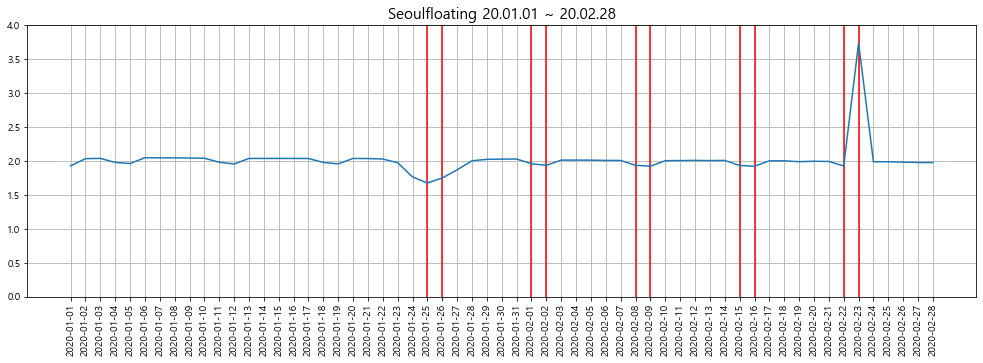

In [40]:
fig, ax = plt.subplots(figsize=(17,5))

plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 4)
plt.grid(True)
plt.plot(x[0:59],(y[0:59])/100000000)
plt.title('Seoulfloating 20.01.01 ~ 20.02.28', fontsize=15)

plt.vlines(x='2020-01-25', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-01-26', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-02-01', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-02-02', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-02-08', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-02-09', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-02-15', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-02-16', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-02-22', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-02-23', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.show()


### 3.2.2. 강도높은 사회적 거리두기(strong) 시행 후 유동성(20.02.29 ~ 20.04.16)

------------------------------------------------------------------------------------------------------------------

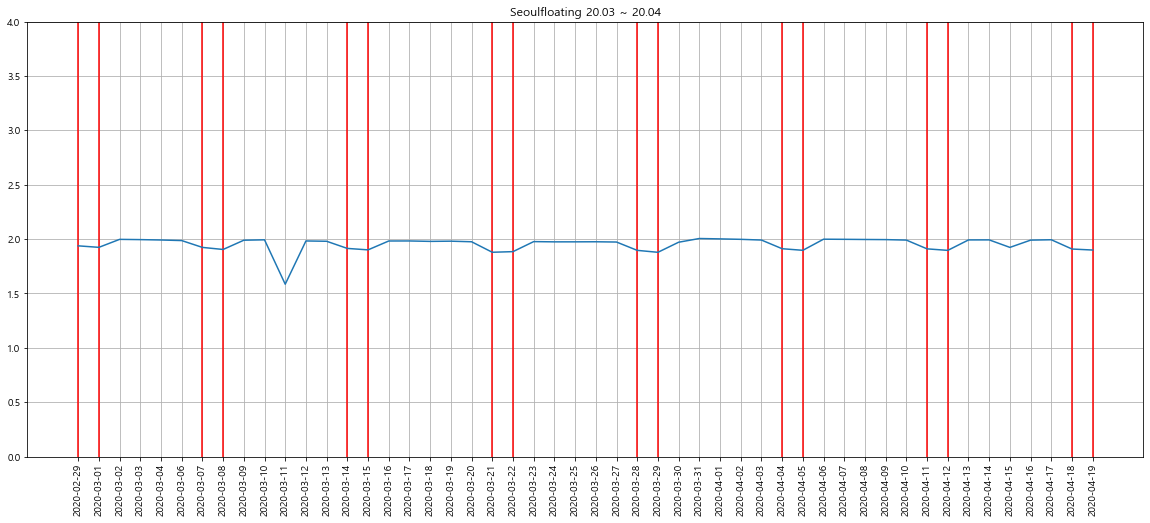

In [41]:
plt.figure(figsize=(20,8))
plt.ylim(0, 4)
plt.grid(True)
plt.xticks(rotation = 90)
plt.plot(x[59:109],(y[59:109])/100000000)
plt.title('Seoulfloating 20.03 ~ 20.04')

plt.vlines(x='2020-02-29', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-01', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-03-07', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-08', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-03-14', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-15', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-03-21', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-22', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-03-28', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-03-29', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-04-04', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-04-05', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-04-11', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-04-12', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-04-18', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-04-19', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.show()

### 3.2.3. 약한 사회적 거리두기(weak) 시행 후 유동성(20.04.17 ~)

------------------------------------------------------------------------------------------------------------------

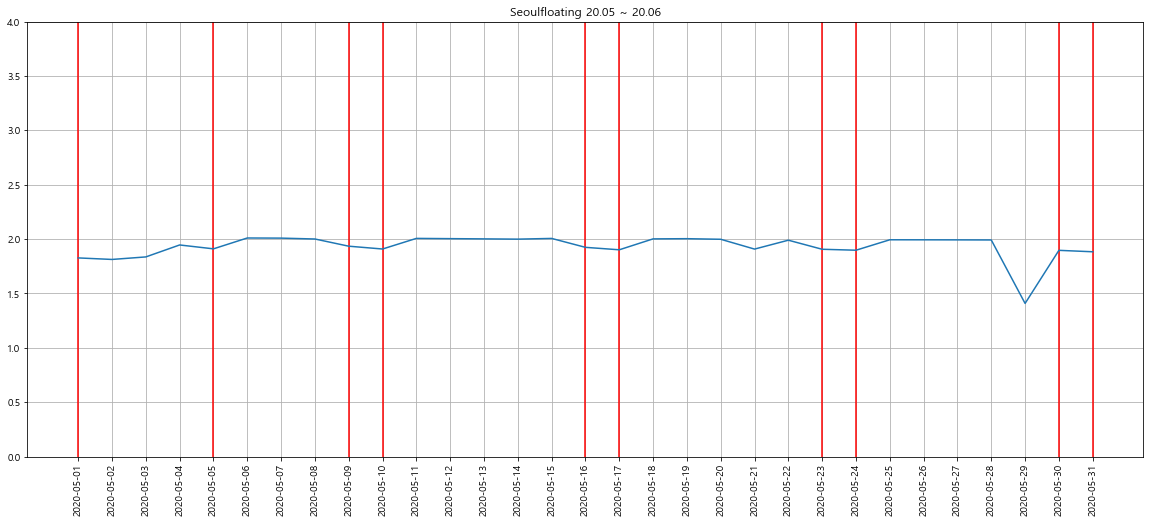

In [42]:
plt.figure(figsize=(20,8))
plt.ylim(0, 4)
plt.grid(True)
plt.xticks(rotation = 90)
plt.plot(x[120:180],(y[120:180])/100000000)
plt.title('Seoulfloating 20.05 ~ 20.06')

plt.vlines(x='2020-05-01', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-05', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-05-09', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-10', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-05-16', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-17', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-05-23', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-24', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.vlines(x='2020-05-30', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')
plt.vlines(x='2020-05-31', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='r')

plt.show()

# 4. 연령대별 확진자 수와 유동인구 - 조양권

In [43]:
patient_info = pd.read_csv("./data/PatientInfo.csv")
floating = pd.read_csv("./data/SeoulFloating.csv")
time = pd.read_csv("./data/Time.csv") 

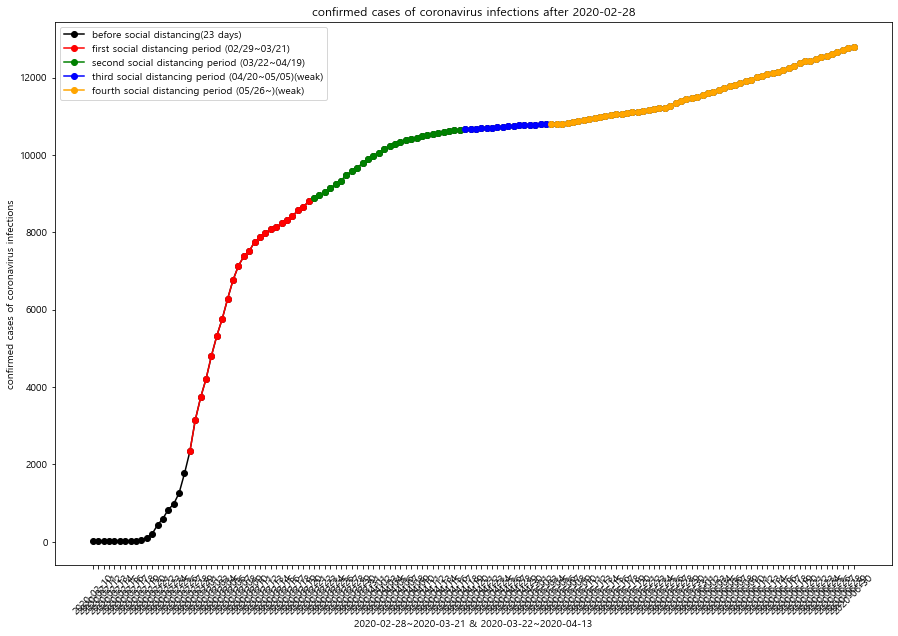

In [44]:
#사회적 거리두기 시행 이전 23일과 시행 이후 23일의 일별 확진자수를 시각화합니다.
date = time['date'] #날짜 column
conNum = time['confirmed'] #확진자수 column
plt.figure()
plt.rcParams['figure.figsize'] = [50, 20] # [width, height]

#사회적 거리두기 이전 23일 동안의 확진자수 그래프 그리기
xbefore=date[21:]  
ybefore=conNum[21:]
plt.plot(xbefore, ybefore, marker='o', color='black', label='before social distancing(23 days)')



xafter=date[39:62]  #첫 사회적 거리두기기간 (02/29~03/21)
yafter=conNum[39:62]
plt.plot(xafter, yafter, marker='o', color='red', label='first social distancing period (02/29~03/21)')

xafter=date[62:90]
yafter=conNum[62:90]
plt.plot(xafter, yafter, marker='o', color='green', label='second social distancing period (03/22~04/19)')

xafter=date[90:106]
yafter=conNum[90:106] 
plt.plot(xafter, yafter, marker='o', color='blue', label='third social distancing period (04/20~05/05)(weak)')

xafter=date[106:len(date)]
yafter=conNum[106:len(conNum)]
plt.plot(xafter, yafter, marker='o', color='orange', label='fourth social distancing period (05/26~)(weak)')


plt.xticks(rotation=45) #x축 글자 기울이기
plt.xlabel("2020-02-28~2020-03-21 & 2020-03-22~2020-04-13")
plt.ylabel("confirmed cases of coronavirus infections")
plt.title("confirmed cases of coronavirus infections after 2020-02-28")
plt.legend()
plt.show()

In [45]:
#유동인구 연령대별로 분류
floating_20= floating.query('birth_year==20')
floating_30= floating.query('birth_year==30')
floating_40= floating.query('birth_year==40')
floating_50= floating.query('birth_year==50')
floating_60= floating.query('birth_year==60')
floating_70= floating.query('birth_year==70')

#dataFrame에서 date, fp_num 행 외에는 필요가 없으므로 이들만 남겨둠. 
floating_20 = floating_20.loc[:,['date', 'fp_num']]
floating_30 = floating_30.loc[:,['date', 'fp_num']]
floating_40 = floating_40.loc[:,['date', 'fp_num']]
floating_50 = floating_50.loc[:,['date', 'fp_num']]
floating_60 = floating_60.loc[:,['date', 'fp_num']]
floating_70 = floating_70.loc[:,['date', 'fp_num']]

#각 날짜에 해당하는 인원 수 합치기
floating_20 = floating_20.groupby(['date'])[['fp_num']].sum()
floating_30 = floating_30.groupby(['date'])[['fp_num']].sum()
floating_40 = floating_40.groupby(['date'])[['fp_num']].sum()
floating_50 = floating_50.groupby(['date'])[['fp_num']].sum()
floating_60 = floating_60.groupby(['date'])[['fp_num']].sum()
floating_70 = floating_70.groupby(['date'])[['fp_num']].sum()

#날짜를 1월 22일부터로 설정. (코로나 확진 환자 처음 생긴 날)
floating_20_date_modify = floating_20[21:]
floating_30_date_modify = floating_30[21:]
floating_40_date_modify = floating_40[21:]
floating_50_date_modify = floating_50[21:]
floating_60_date_modify = floating_60[21:]
floating_70_date_modify = floating_70[21:]

#index 초기화해주기
floating_20_date_modify1 = floating_20_date_modify.reset_index()
floating_30_date_modify1 = floating_30_date_modify.reset_index()
floating_40_date_modify1 = floating_40_date_modify.reset_index()
floating_50_date_modify1 = floating_50_date_modify.reset_index()
floating_60_date_modify1 = floating_60_date_modify.reset_index()
floating_70_date_modify1 = floating_70_date_modify.reset_index()

In [46]:
floating_20_date_modify1.at[31, 'fp_num']
floating_20_date_modify1.at[32, 'fp_num']
floating_20_date_modify1.at[31, 'fp_num']

35458810

In [47]:
floating_20_date_modify1.at[32, 'fp_num'] = floating_20_date_modify1.at[32, 'fp_num']*(1/1.92)
floating_30_date_modify1.at[32, 'fp_num'] = floating_30_date_modify1.at[32, 'fp_num']*(1/1.92)
floating_40_date_modify1.at[32, 'fp_num'] = floating_40_date_modify1.at[32, 'fp_num']*(1/1.92)
floating_50_date_modify1.at[32, 'fp_num'] = floating_50_date_modify1.at[32, 'fp_num']*(1/1.92)
floating_60_date_modify1.at[32, 'fp_num'] = floating_60_date_modify1.at[32, 'fp_num']*(1/1.92)
floating_70_date_modify1.at[32, 'fp_num'] = floating_70_date_modify1.at[32, 'fp_num']*(1/1.92)

In [48]:
floating_20_date_modify1

,date,fp_num
0,2020-01-22,36066830
1,2020-01-23,34611120
2,2020-01-24,29333360
3,2020-01-25,26769130
4,2020-01-26,29136330
...,...,...
125,2020-05-27,36798640
126,2020-05-28,36811520
127,2020-05-29,26027020
128,2020-05-30,35840240


In [49]:
#서울 사람들만 분류
patient = patient_info.query('province == "Seoul"')

#환자 연령대별로 분류
patient_20= patient.query('age=="20s"')
patient_30= patient.query('age=="30s"')
patient_40= patient.query('age=="40s"')
patient_50= patient.query('age=="50s"')
patient_60= patient.query('age=="60s"')
patient_70= patient.query('age=="70s"')

#confirmed_date column만 불러온다
patient_20 = patient_20.loc[:,['confirmed_date']]
patient_30 = patient_30.loc[:,['confirmed_date']]
patient_40 = patient_40.loc[:,['confirmed_date']]
patient_50 = patient_50.loc[:,['confirmed_date']]
patient_60 = patient_60.loc[:,['confirmed_date']]
patient_70 = patient_70.loc[:,['confirmed_date']]

#각 날짜별 사람 수 통합
#인원수 파악을 위해 1이 들어간 column 새로 만들어 준다
patient_20['patient']=np.nan
patient_20.loc[:,['patient']]=1
patient_30['patient']=np.nan
patient_30.loc[:,['patient']]=1
patient_40['patient']=np.nan
patient_40.loc[:,['patient']]=1
patient_50['patient']=np.nan
patient_50.loc[:,['patient']]=1
patient_60['patient']=np.nan
patient_60.loc[:,['patient']]=1
patient_70['patient']=np.nan
patient_70.loc[:,['patient']]=1

#각 날짜별 확진자 수 
patient_20 = patient_20.groupby(['confirmed_date'])[['patient']].sum()
patient_20.columns.name = 'date'
patient_30 = patient_30.groupby(['confirmed_date'])[['patient']].sum()
patient_30.columns.name = 'date'
patient_40 = patient_40.groupby(['confirmed_date'])[['patient']].sum()
patient_40.columns.name = 'date'
patient_50 = patient_50.groupby(['confirmed_date'])[['patient']].sum()
patient_50.columns.name = 'date'
patient_60 = patient_60.groupby(['confirmed_date'])[['patient']].sum()
patient_60.columns.name = 'date'
patient_70 = patient_70.groupby(['confirmed_date'])[['patient']].sum()
patient_70.columns.name = 'date'

#index 초기화
patient_20=patient_20.reset_index()
patient_30=patient_30.reset_index()
patient_40=patient_40.reset_index()
patient_50=patient_50.reset_index()
patient_60=patient_60.reset_index()
patient_70=patient_70.reset_index()

#이후에 merge 할 수 있게 patient data의 column 이름을 floating data의 column과 똑같이 맞춰준다
#또한, 아직 floating data가 2/29일까지 없으므로 floating data는 2/29일까지, 확진자 데이터는 2/29일에서 14일 후인 3/14일까지 나타냈음.
#각 patient data를 3/14일까지의 데이터로만 추리는 작업은 각 set을 보고 몇 번째 col이 3/14인지 체크하는 수작업을 했음. 
patient_20.rename(columns={"confirmed_date":"date"}, inplace = True)
patient_20_2=patient_20[8:111]
patient_30.rename(columns={"confirmed_date":"date"}, inplace = True)
patient_30_2=patient_30[:]
patient_40.rename(columns={"confirmed_date":"date"}, inplace = True)
patient_40_2=patient_40[:]
patient_50.rename(columns={"confirmed_date":"date"}, inplace = True)
patient_50_2=patient_50[:]
patient_60.rename(columns={"confirmed_date":"date"}, inplace = True)
patient_60_2=patient_60[:]
patient_70.rename(columns={"confirmed_date":"date"}, inplace = True)
patient_70_2=patient_70[:]

#각 날짜에 대한 유동인구, 확진자 수 한 dataFrame에 묶기
#Nan data에는 0을 넣어줌. 
combine_20_2= pd.merge(floating_20_date_modify1,patient_20_2,how='outer',on='date')
combine_20_2 = combine_20_2.fillna(0)
combine_30_2= pd.merge(floating_30_date_modify1,patient_30_2,how='outer',on='date')
combine_30_2 = combine_30_2.fillna(0)
combine_40_2= pd.merge(floating_40_date_modify1,patient_40_2,how='outer',on='date')
combine_40_2 = combine_40_2.fillna(0)
combine_50_2= pd.merge(floating_50_date_modify1,patient_50_2,how='outer',on='date')
combine_50_2 = combine_50_2.fillna(0)
combine_60_2= pd.merge(floating_60_date_modify1,patient_60_2,how='outer',on='date')
combine_60_2 = combine_60_2.fillna(0)
combine_70_2= pd.merge(floating_70_date_modify1,patient_70_2,how='outer',on='date')
combine_70_2 = combine_70_2.fillna(0)

In [50]:
floating_20_date_modify1

,date,fp_num
0,2020-01-22,36066830
1,2020-01-23,34611120
2,2020-01-24,29333360
3,2020-01-25,26769130
4,2020-01-26,29136330
...,...,...
125,2020-05-27,36798640
126,2020-05-28,36811520
127,2020-05-29,26027020
128,2020-05-30,35840240


In [51]:
patient_20

date,date,patient
0,2020-01-30,1
1,2020-01-31,2
2,2020-02-02,1
3,2020-02-07,1
4,2020-02-20,1
5,2020-02-24,1
6,2020-02-26,5
7,2020-02-27,4
8,2020-02-28,1
9,2020-02-29,3


In [52]:
patient_20_2

date,date,patient
8,2020-02-28,1
9,2020-02-29,3
10,2020-03-01,2
11,2020-03-02,2
12,2020-03-04,1
13,2020-03-07,1
14,2020-03-08,3
15,2020-03-09,2
16,2020-03-10,7
17,2020-03-11,7


In [53]:
combine_20_2

,date,fp_num,patient
0,2020-01-22,36066830,0.0
1,2020-01-23,34611120,0.0
2,2020-01-24,29333360,0.0
3,2020-01-25,26769130,0.0
4,2020-01-26,29136330,0.0
...,...,...,...
125,2020-05-27,36798640,0.0
126,2020-05-28,36811520,0.0
127,2020-05-29,26027020,0.0
128,2020-05-30,35840240,0.0


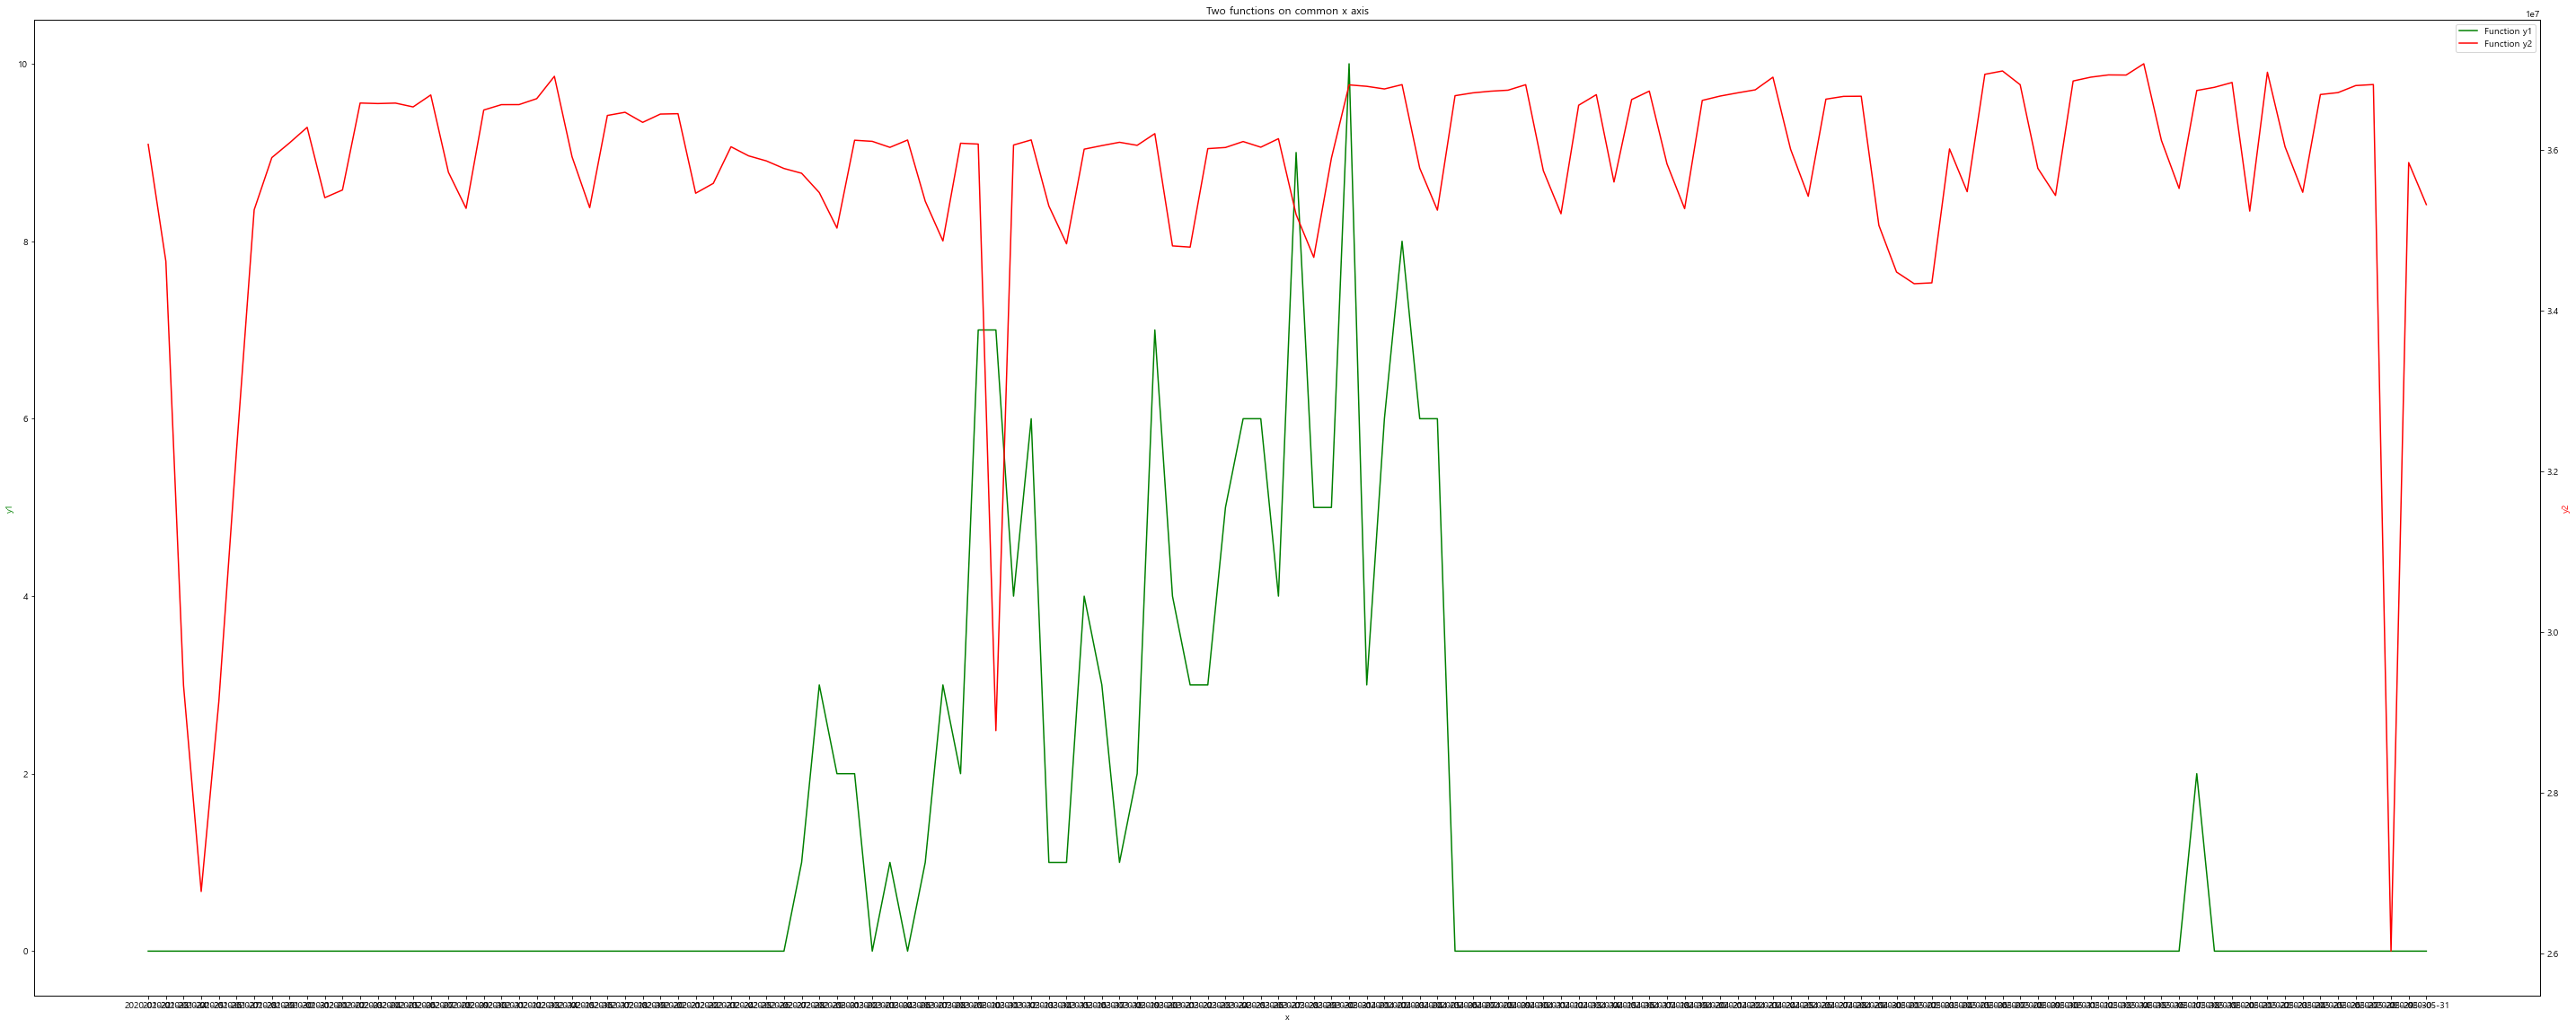

In [54]:
# create some data
x= combine_20_2['date']                 # values of x
y1= combine_20_2['patient']     # values of y1(x)
y2= combine_20_2['fp_num']  # svalues of y2(x)

fig = plt.figure()
ax1 = fig.add_subplot(111)

# create line plot of y1(x)
line1, = ax1.plot(x, y1, 'g', label="Function y1")
ax1.set_xlabel('x')
ax1.set_ylabel('y1', color='g')

# create shared axis for y2(x)
ax2 = ax1.twinx()

# create line plot of y2(x)
line2, = ax2.plot(x, y2, 'r', label="Function y2")
# ax1.set_xlabel('x')
ax2.set_ylabel('y2', color='r')

# set title, plot limits, etc
plt.title('Two functions on common x axis')
# plt.xlim(-2, 18)
# plt.ylim(0, 25)

# add a legend, and position it on the upper right
plt.legend((line1, line2), ('Function y1', 'Function y2'))

plt.show()

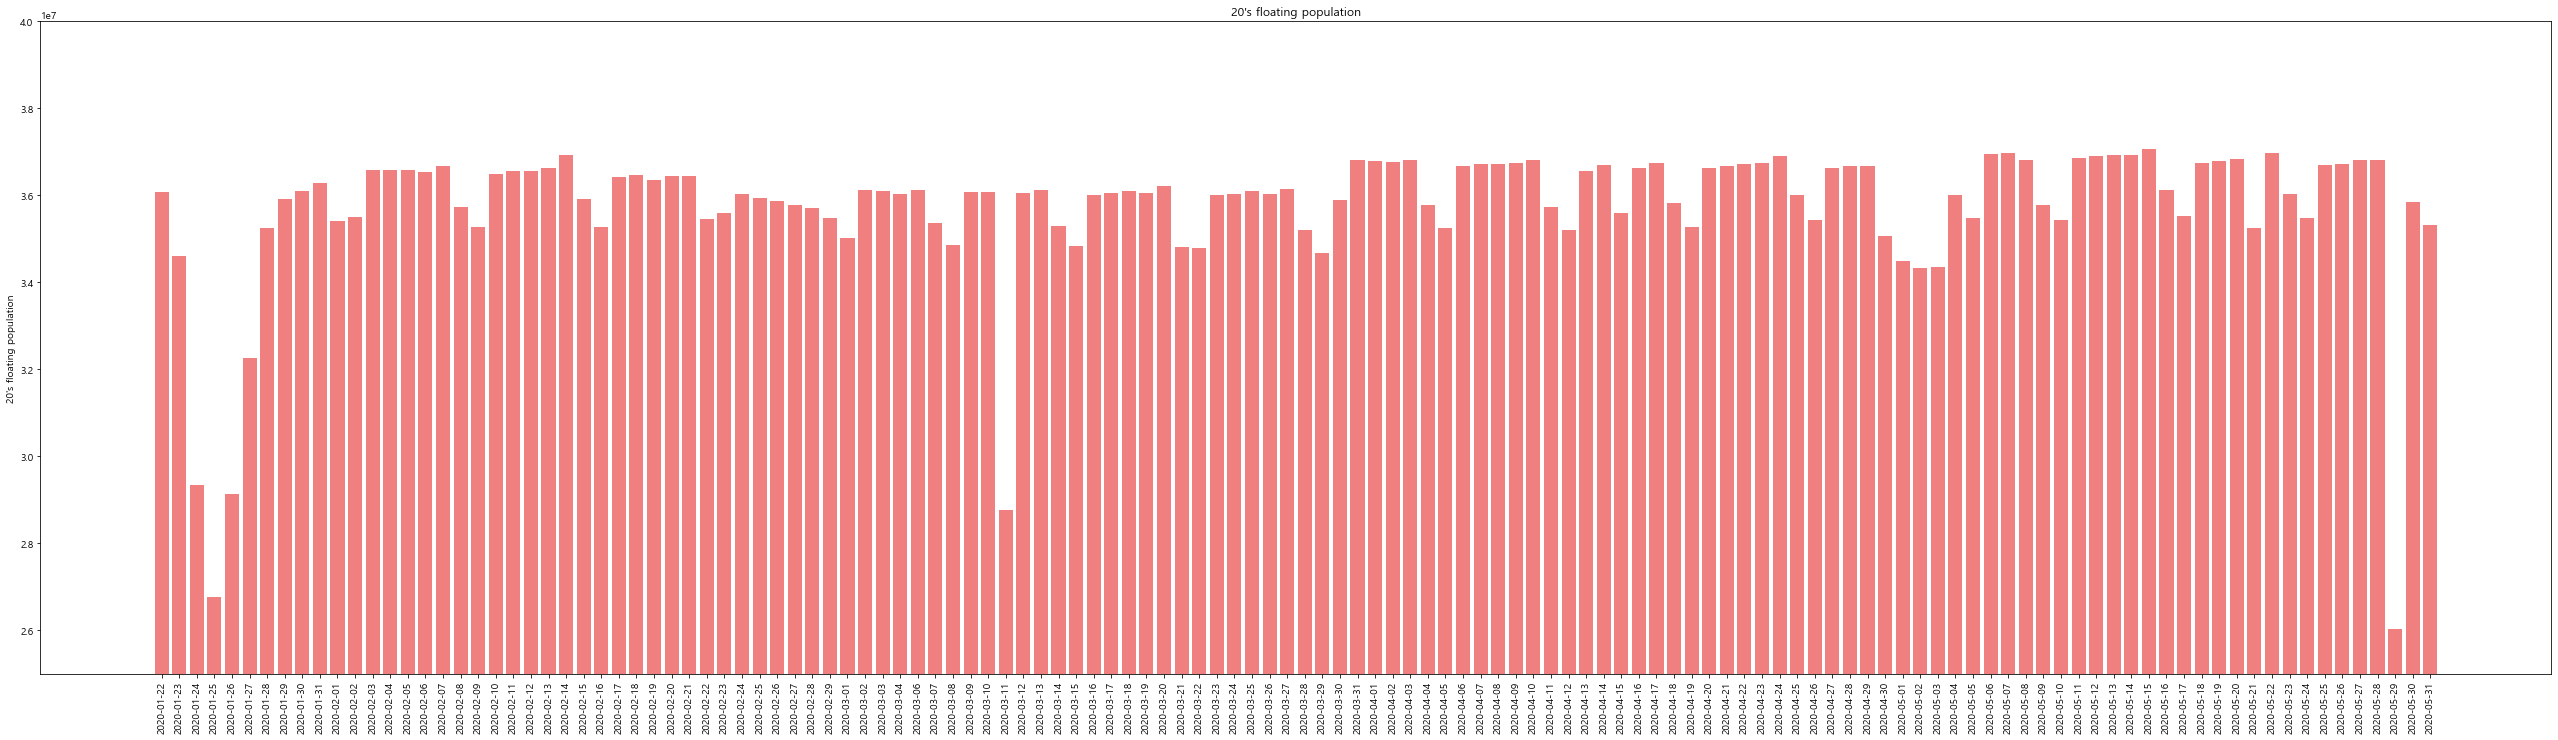

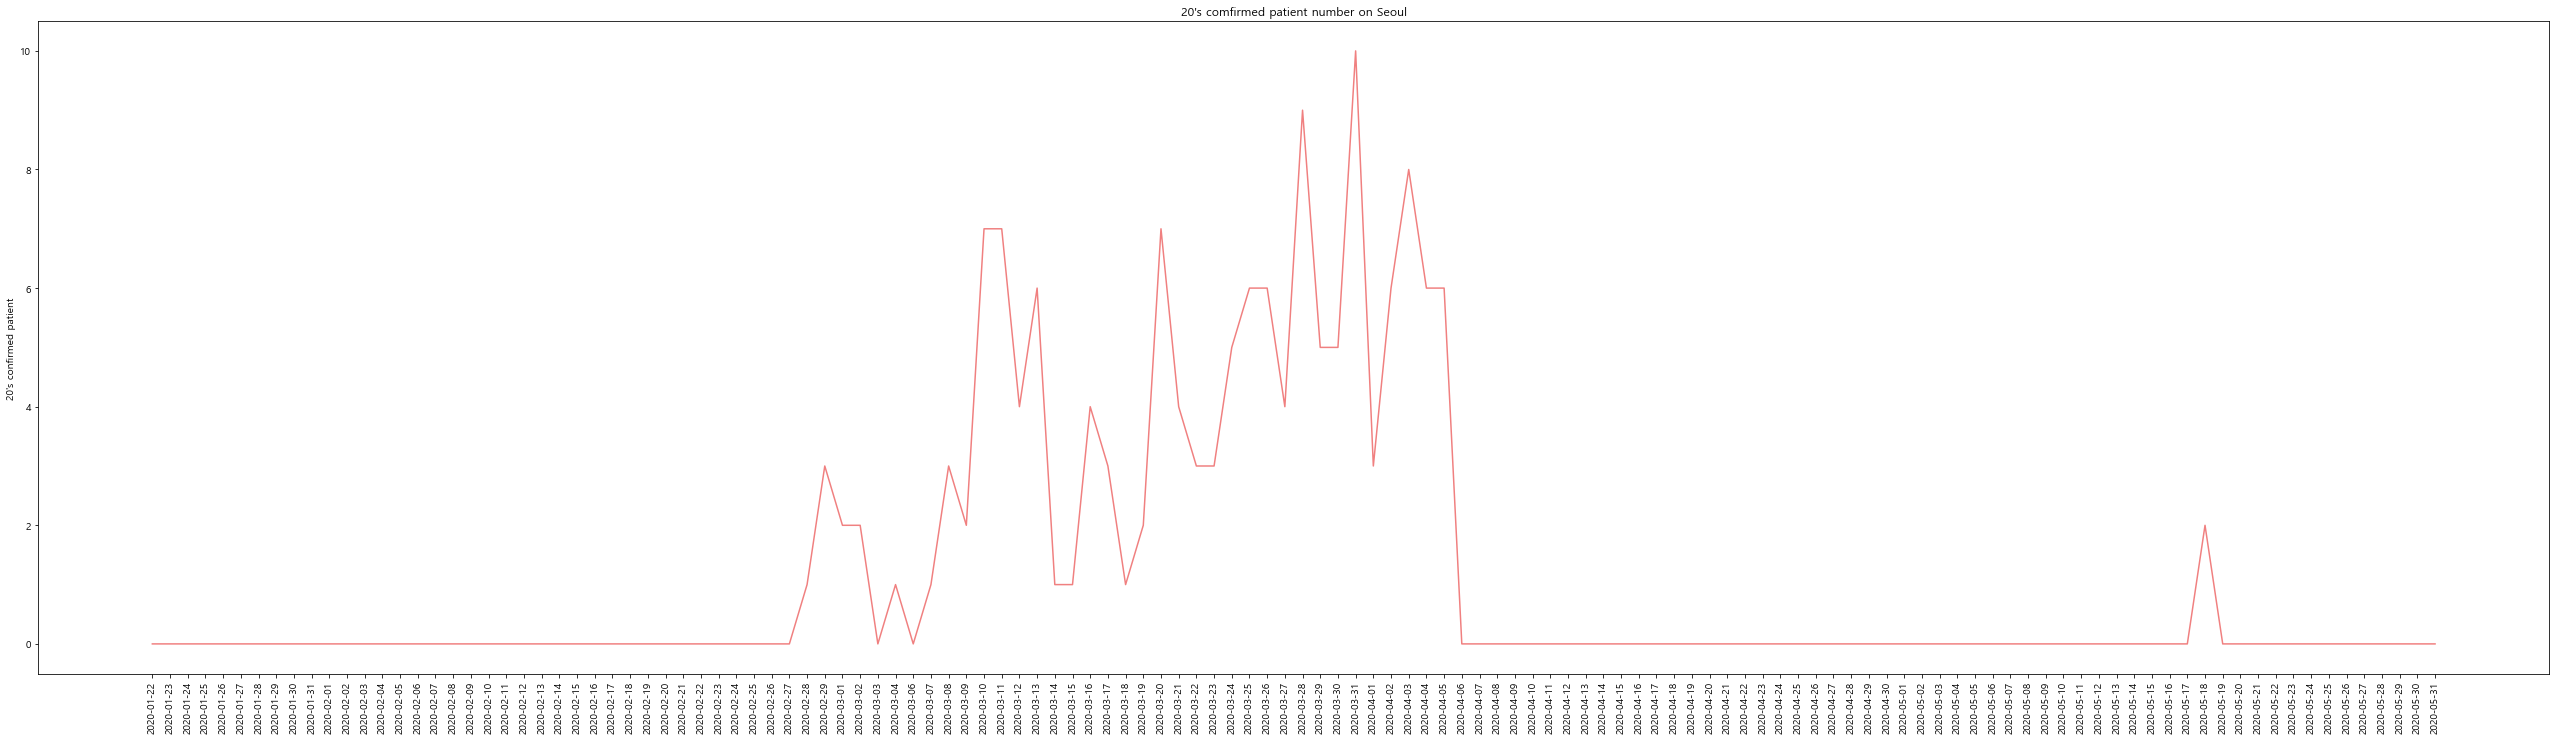

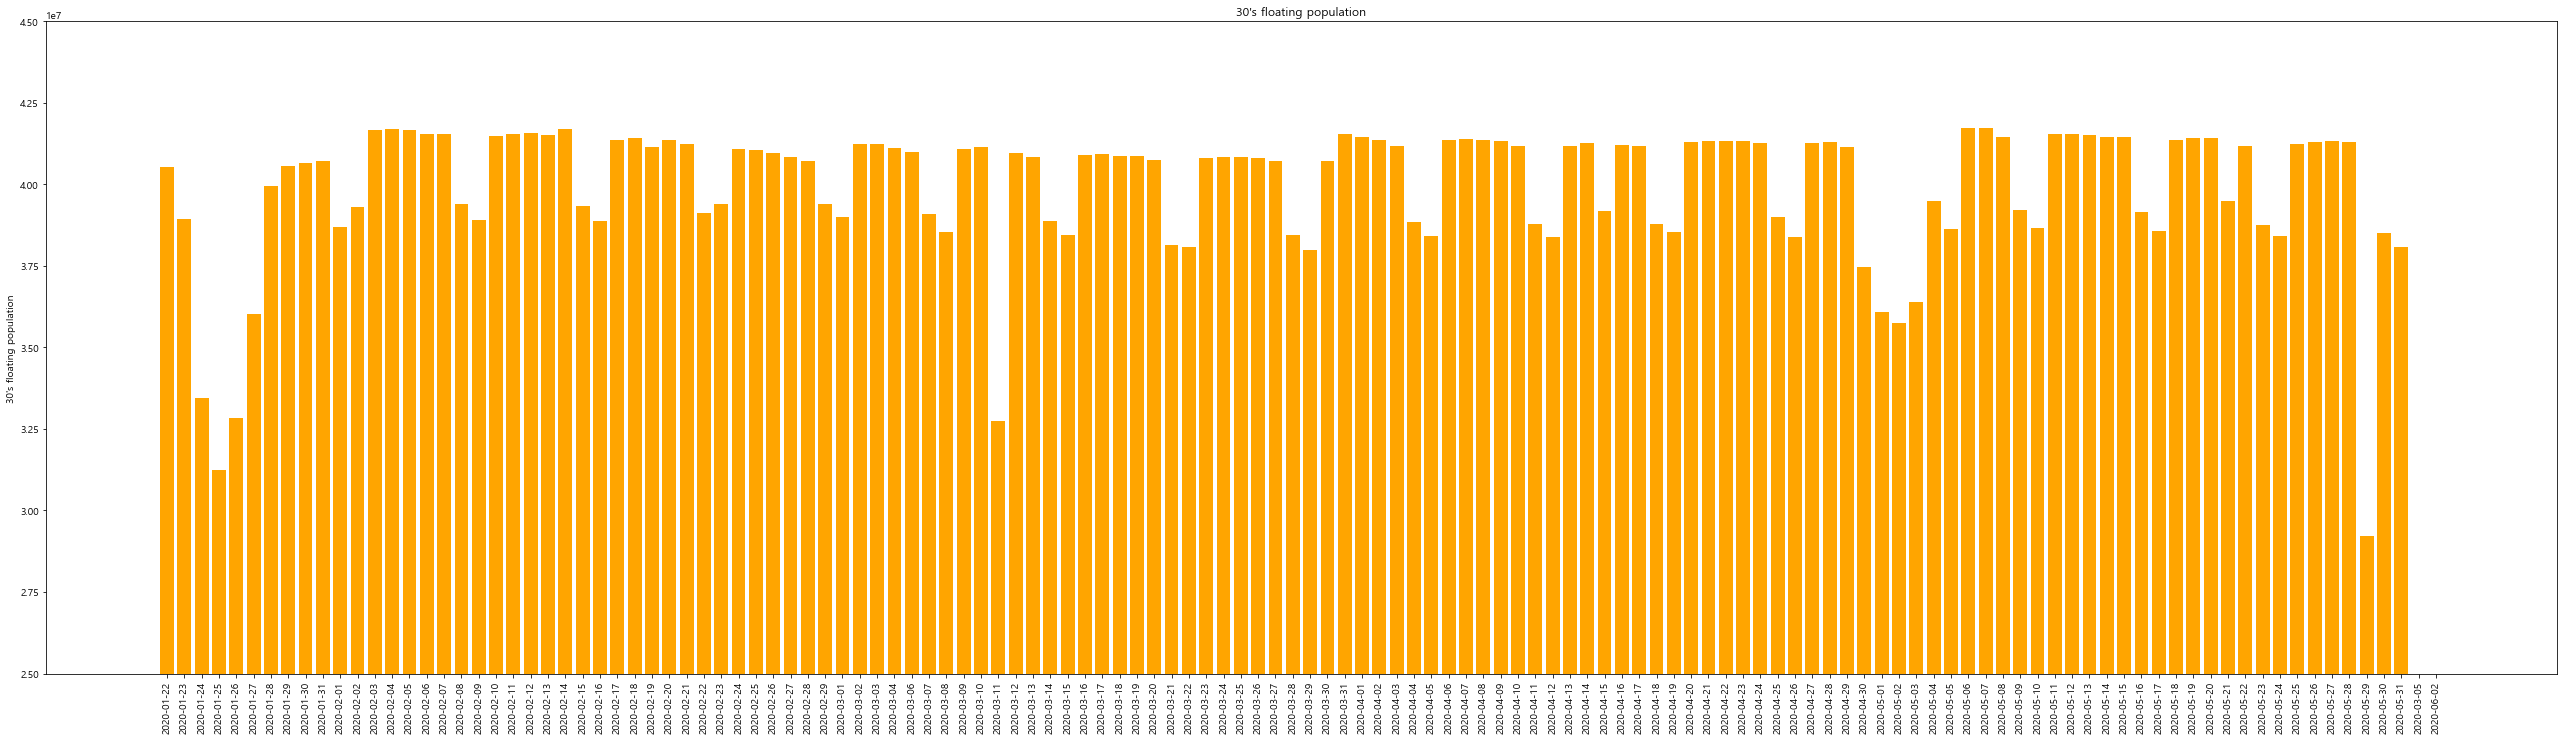

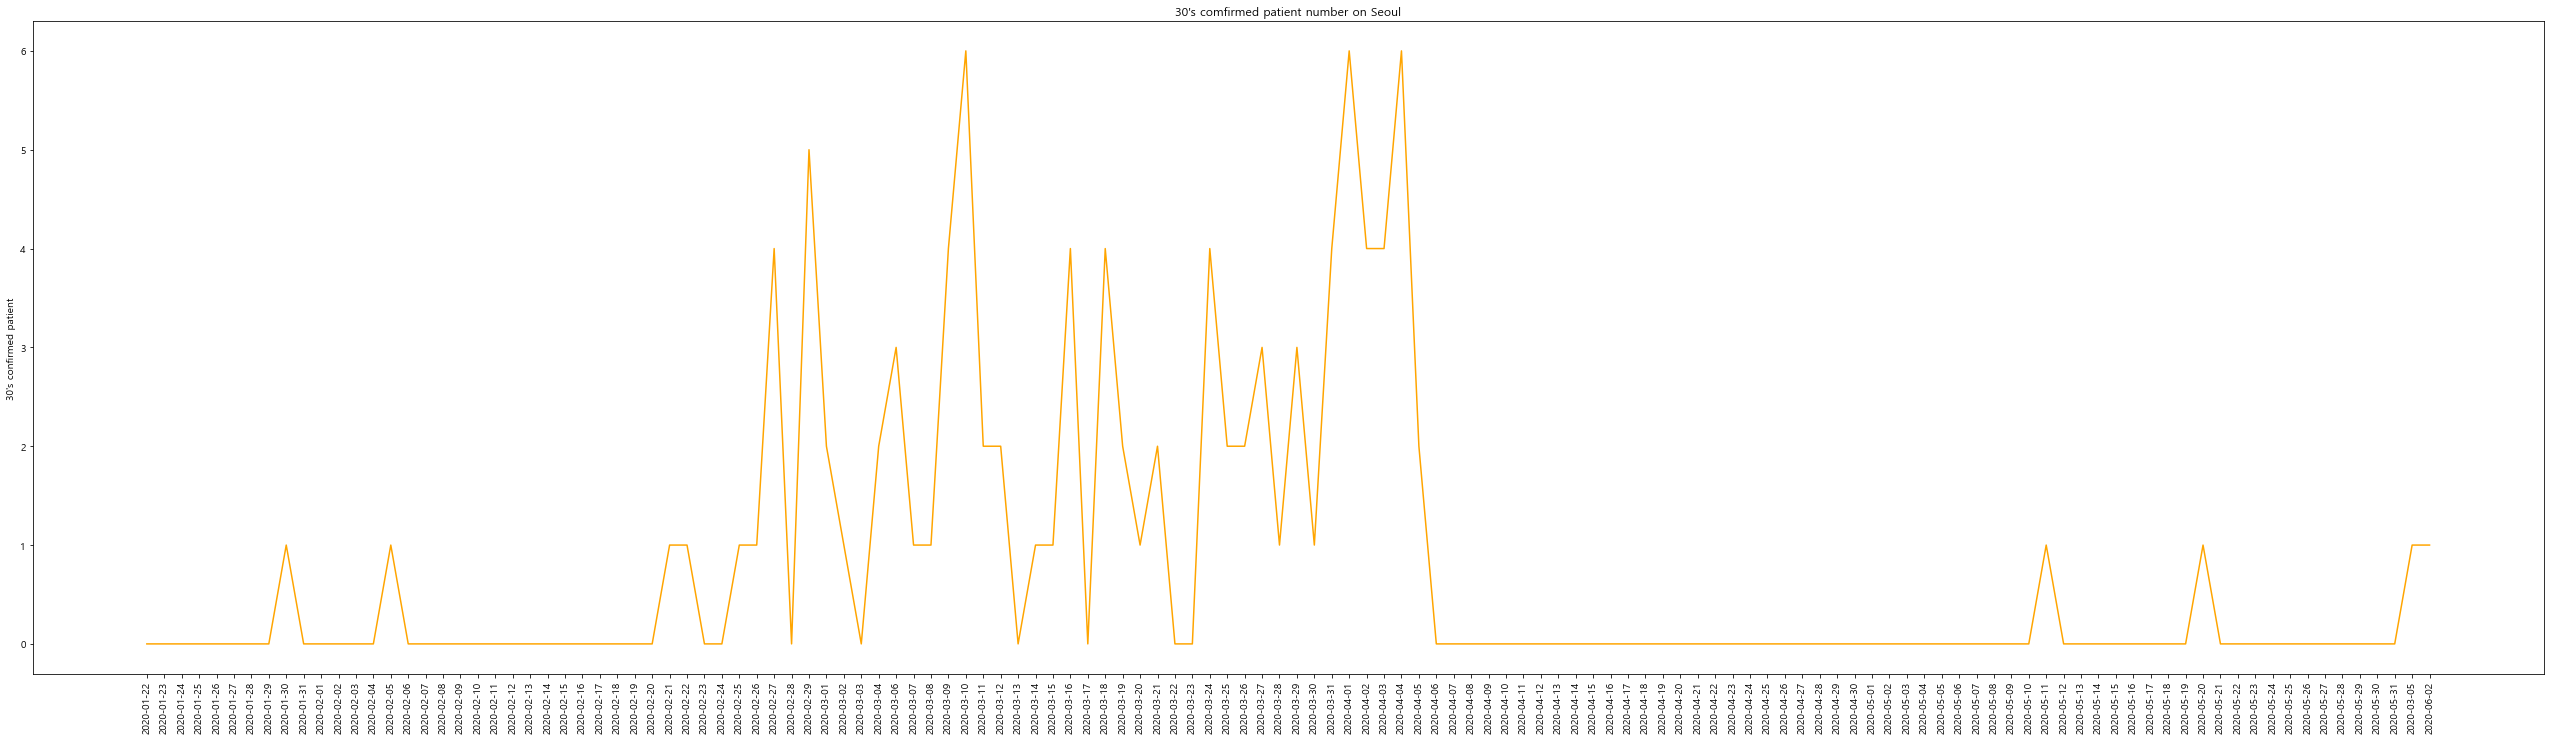

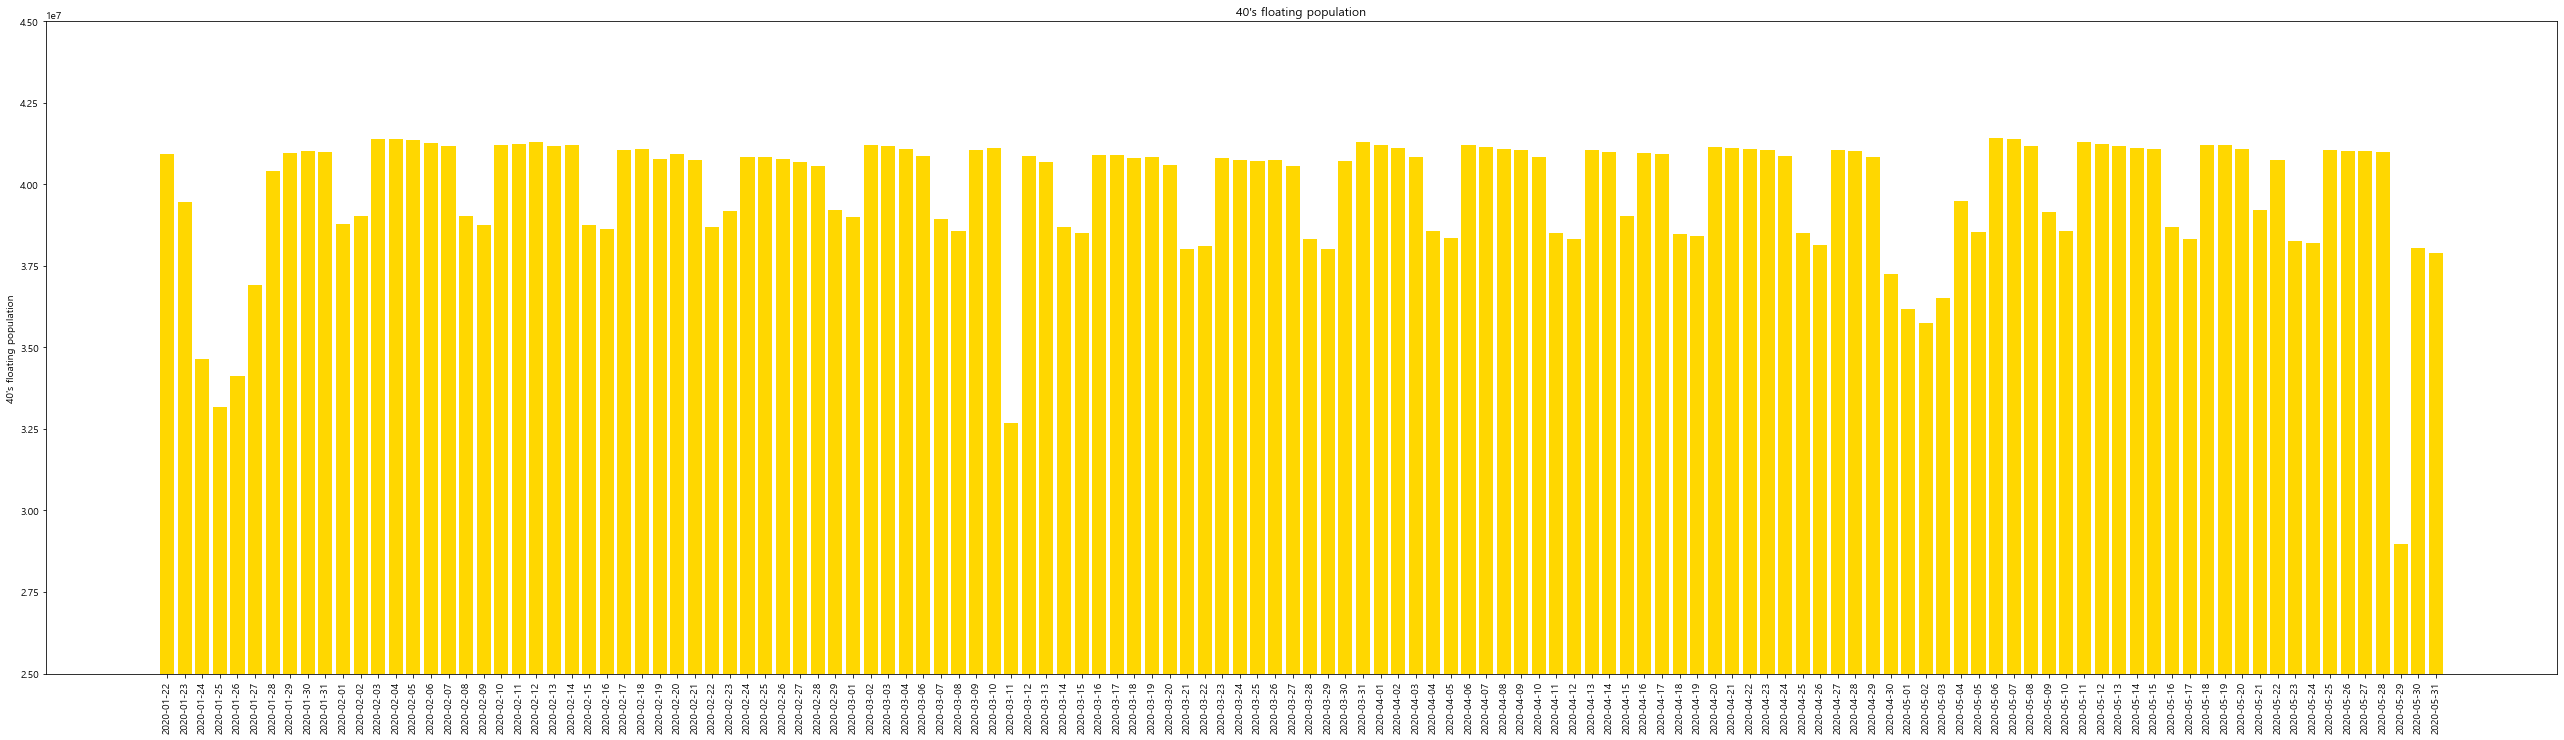

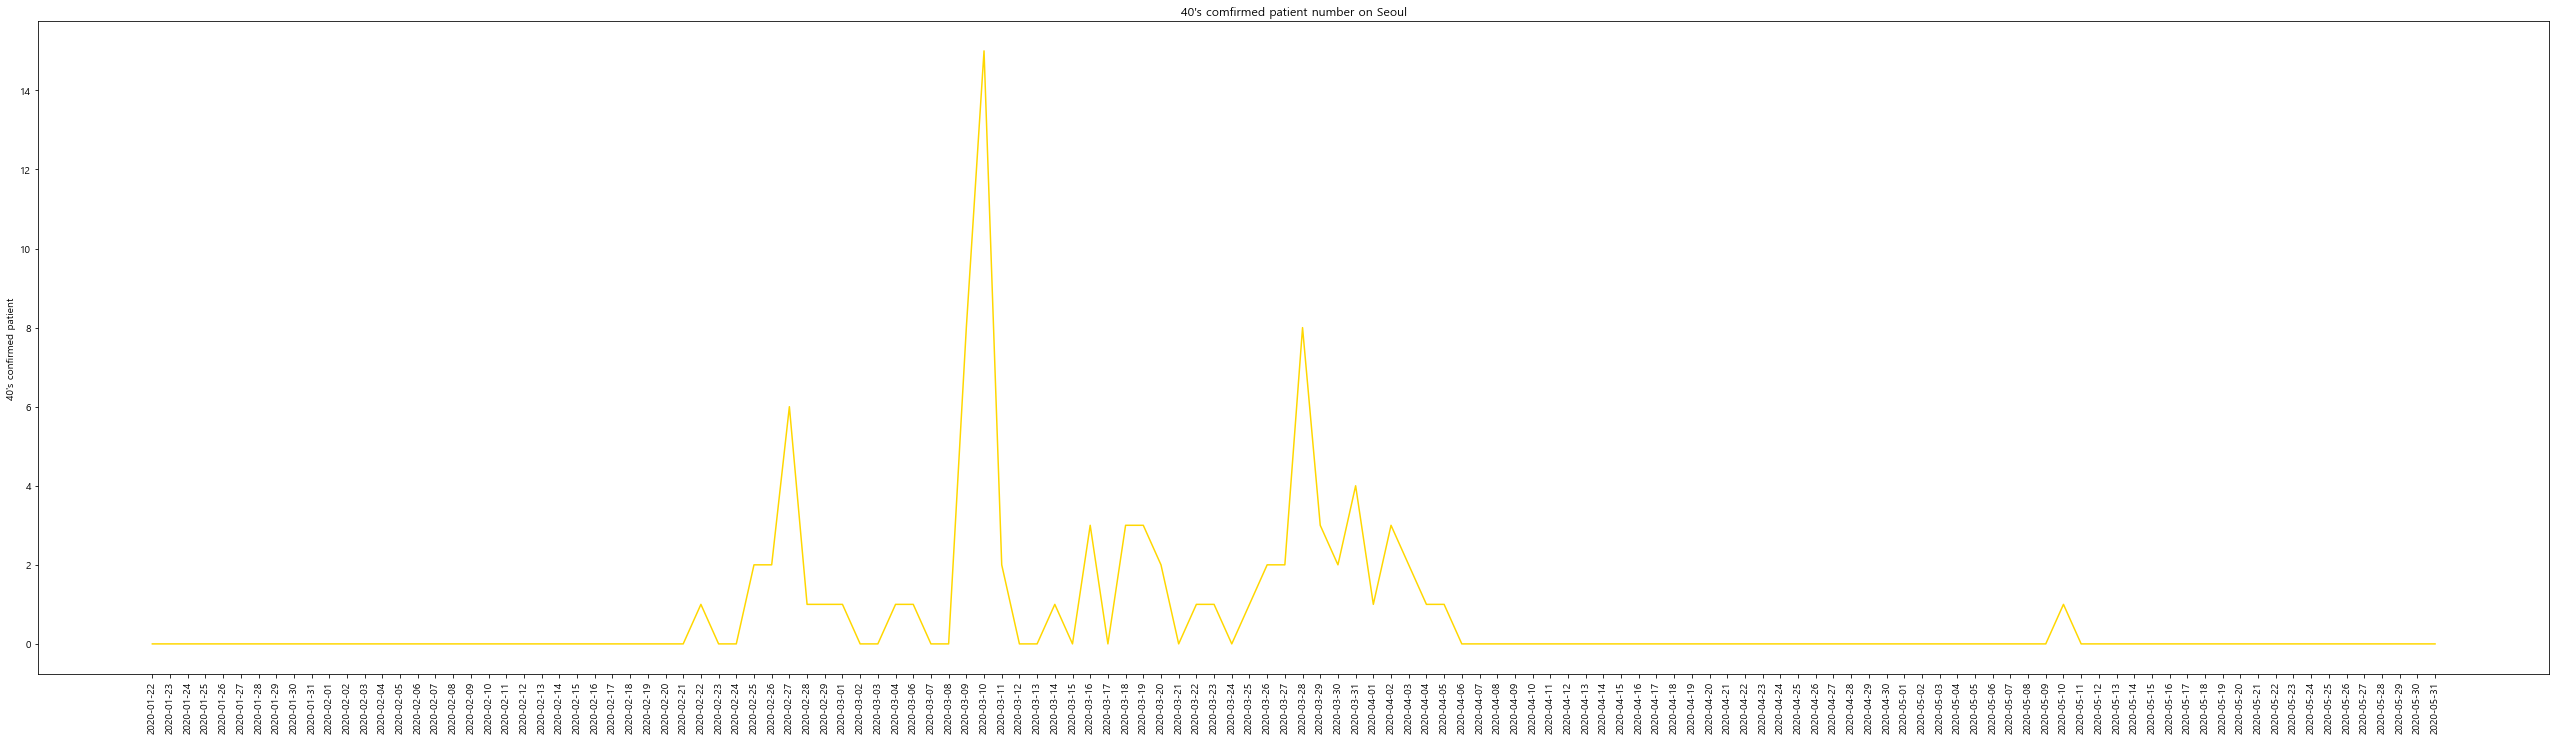

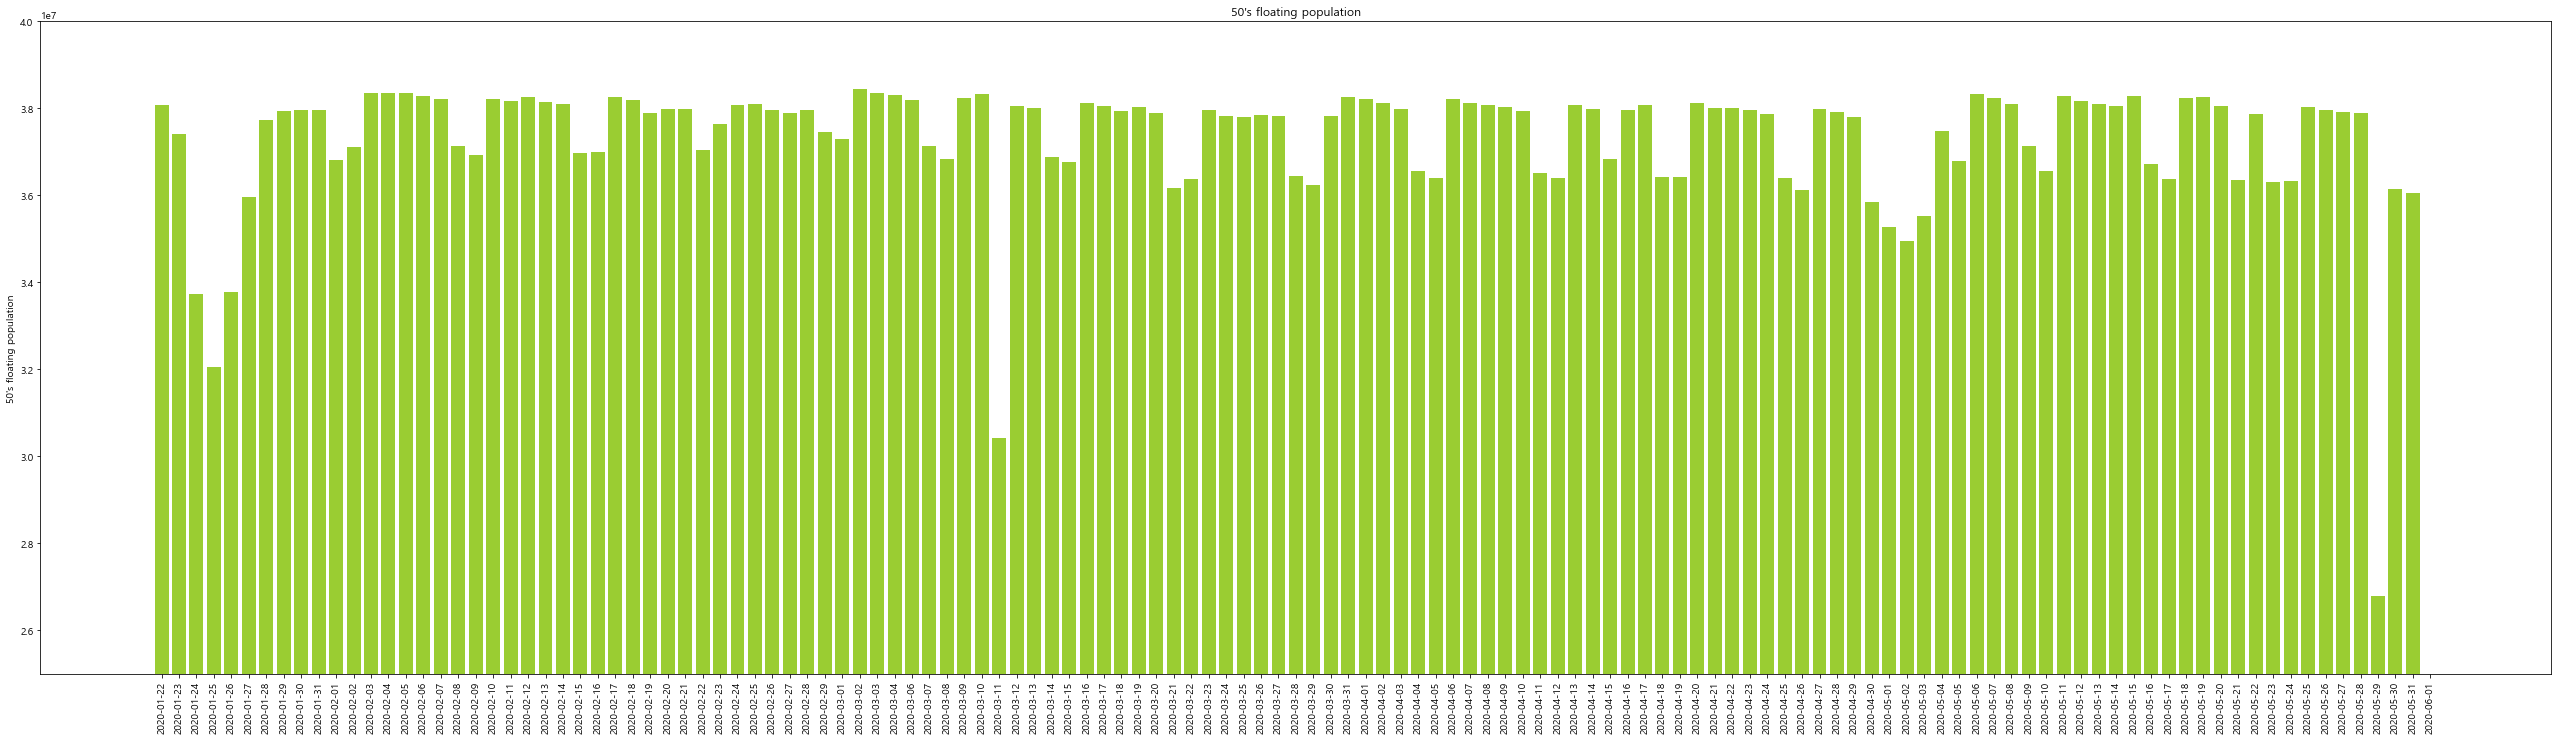

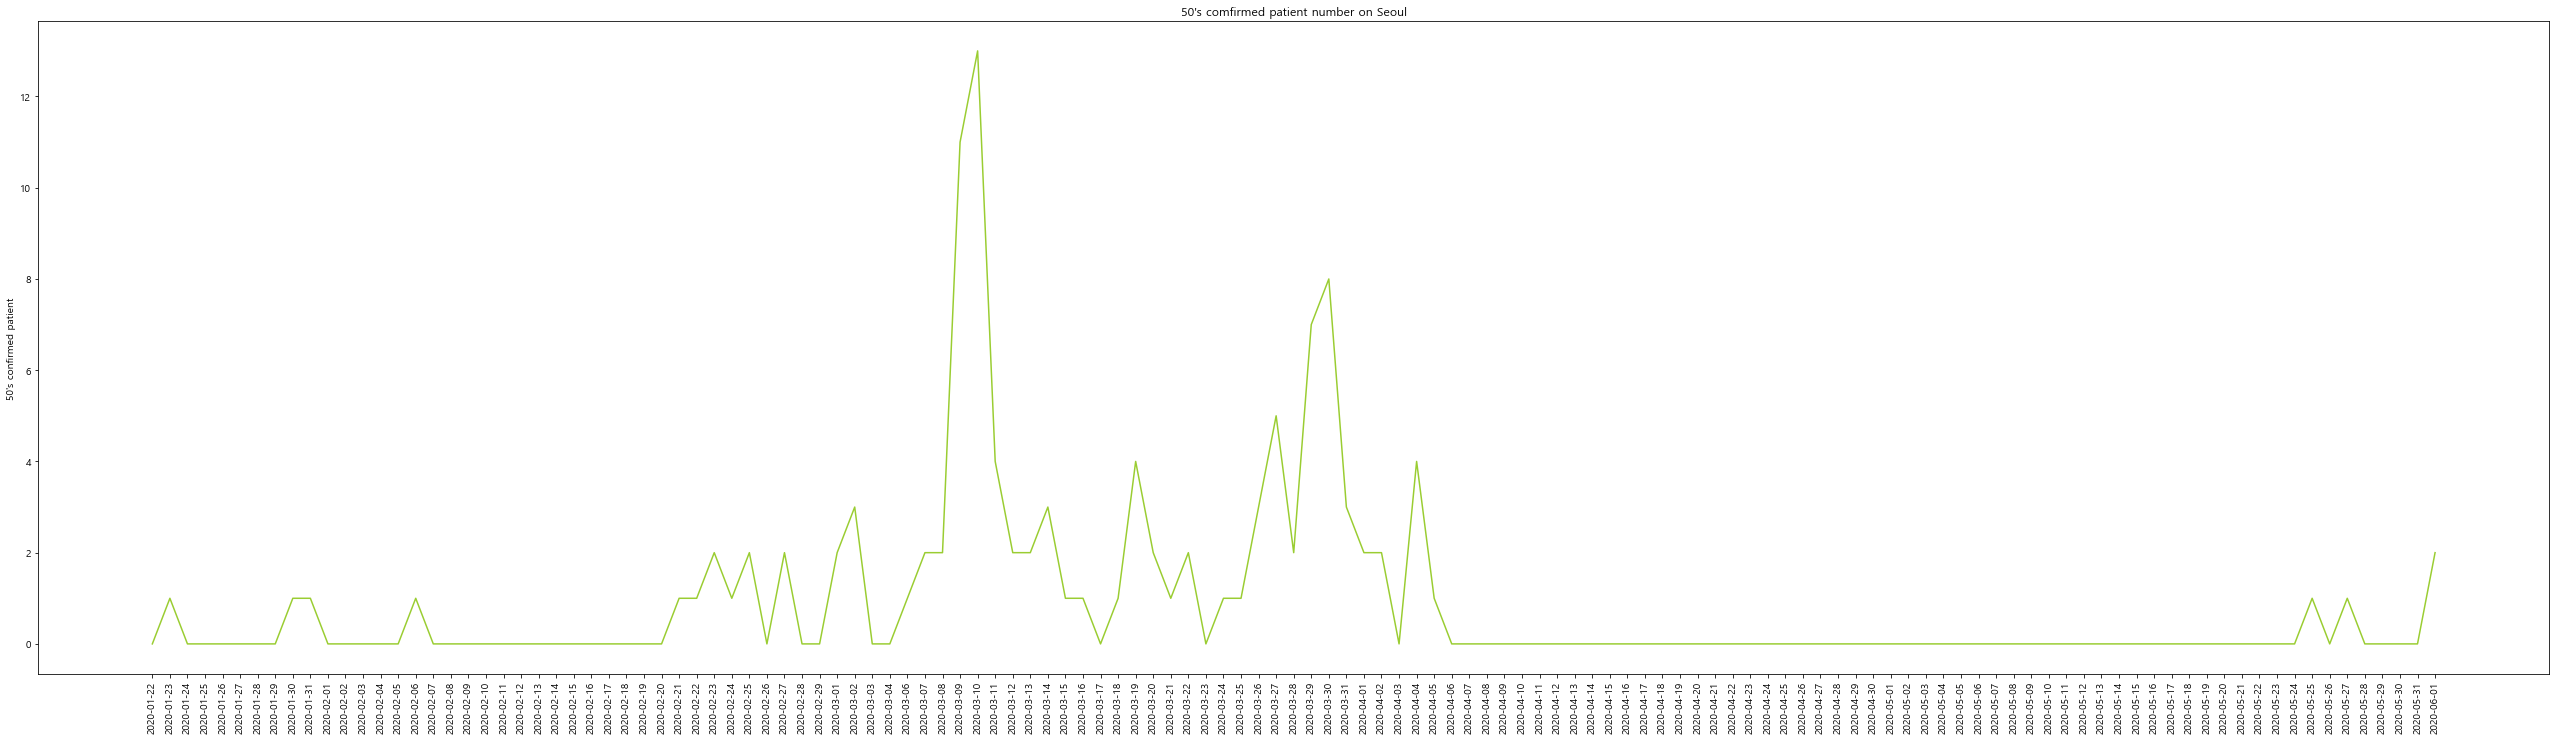

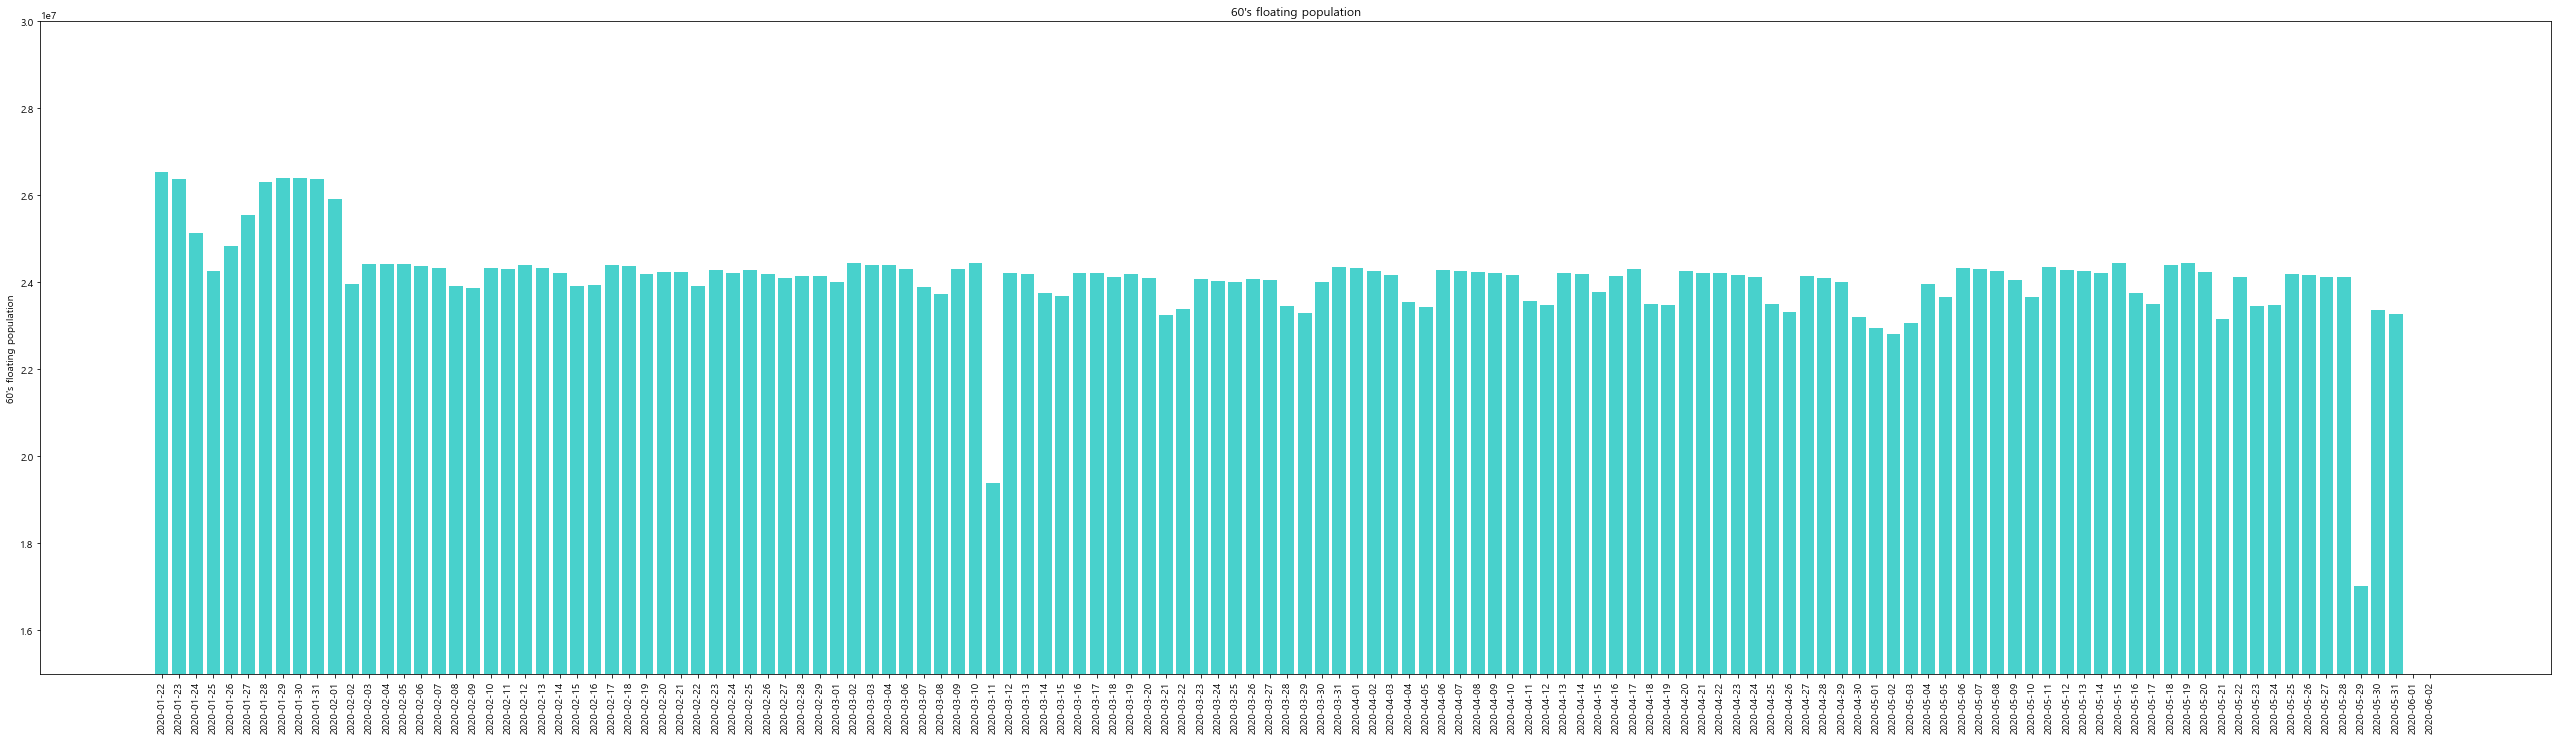

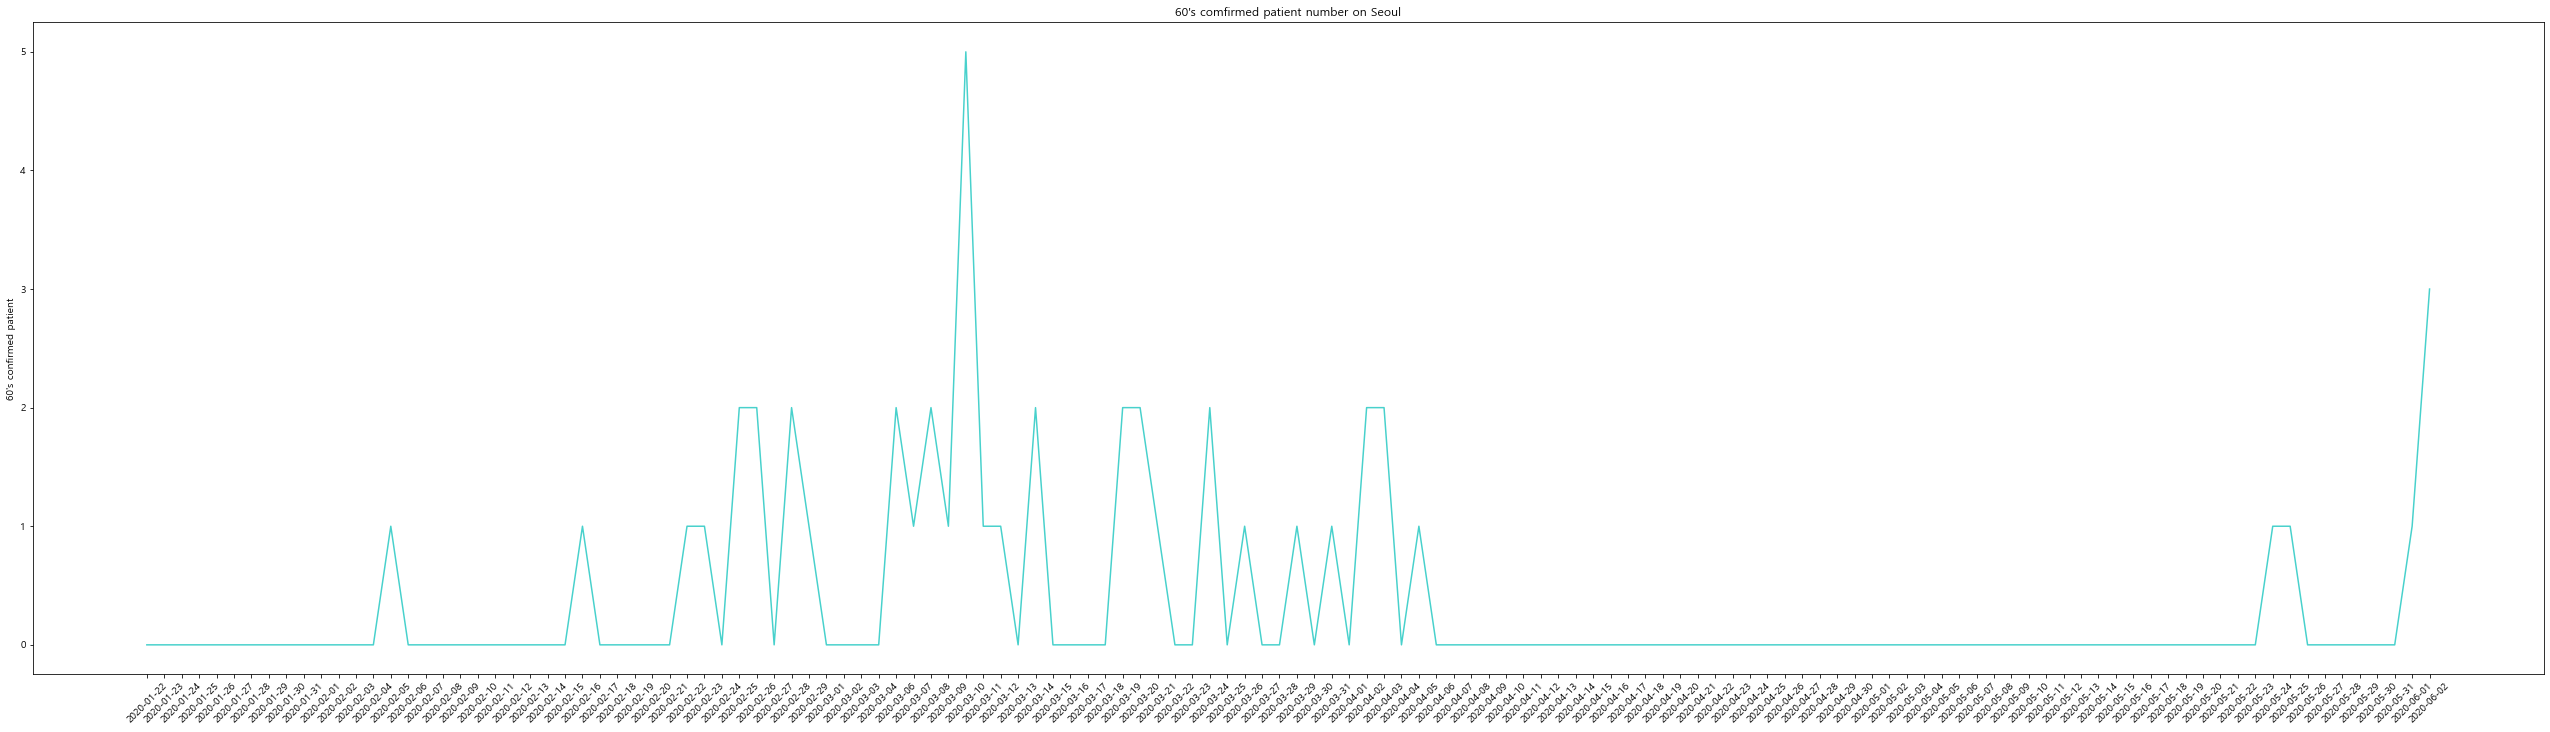

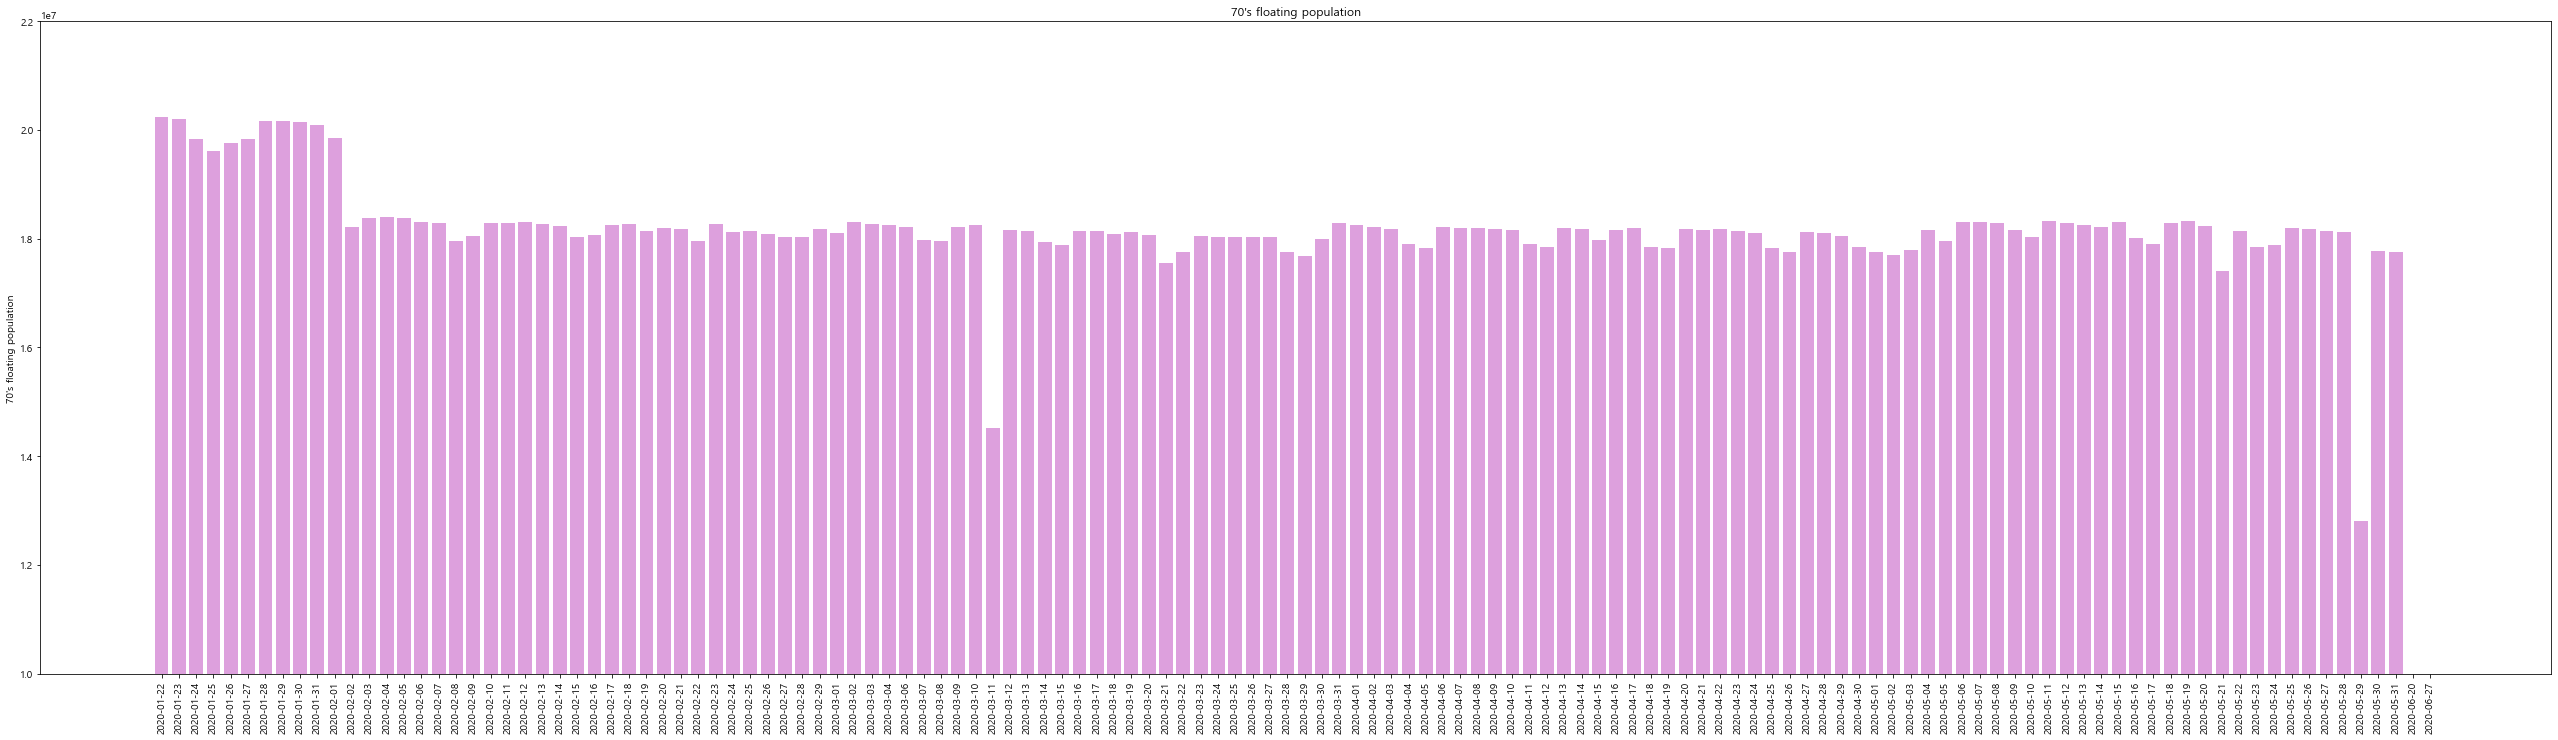

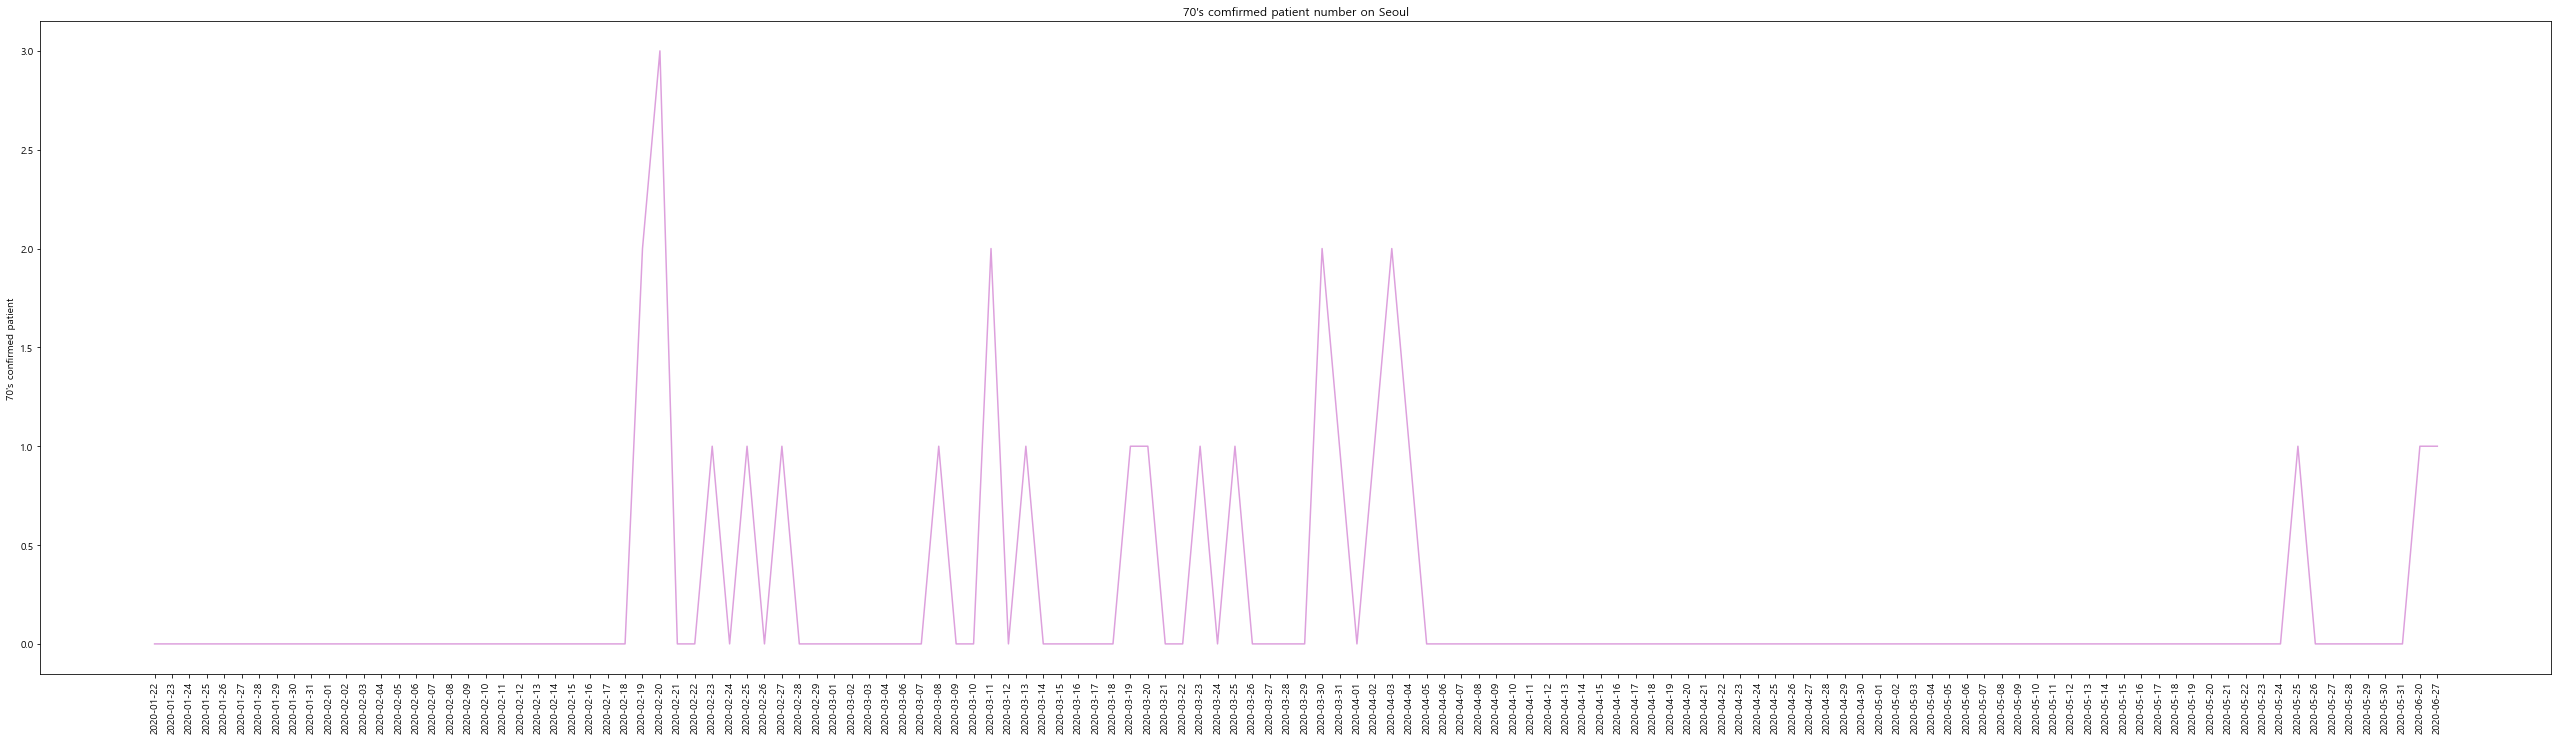

In [55]:
#그래프 그리기

#20대
x= combine_20_2['date']
y1= combine_20_2['patient']
y2= combine_20_2['fp_num']
plt.figure(figsize=(45,12))
plt.bar(x,y2,color='lightcoral')
plt.ylim(25000000,40000000)
plt.title("20's floating population")
plt.xticks(rotation=90)
plt.ylabel("20's floating population")
plt.show()

plt.figure(figsize=(45,12))
plt.plot(x,y1,color='lightcoral')
plt.title("20's comfirmed patient number on Seoul")
plt.xticks(rotation=90)
plt.ylabel("20's confirmed patient")
plt.show()



#30대
x= combine_30_2['date']
y1= combine_30_2['patient']
y2= combine_30_2['fp_num']
plt.figure(figsize=(45,12))
plt.bar(x,y2,color='orange')
plt.ylim(25000000,45000000)
plt.title("30's floating population")
plt.xticks(rotation=90)
plt.ylabel("30's floating population")
plt.show()

plt.figure(figsize=(45,12))
plt.plot(x,y1,color='orange')
plt.title("30's comfirmed patient number on Seoul")
plt.xticks(rotation=90)
plt.ylabel("30's confirmed patient")
plt.show()

#40대 
x= combine_40_2['date']
y1= combine_40_2['patient']
y2= combine_40_2['fp_num']
plt.figure(figsize=(45,12))
plt.bar(x,y2,color='gold')
plt.ylim(25000000,45000000)
plt.title("40's floating population")
plt.xticks(rotation=90)
plt.ylabel("40's floating population")
plt.show()

plt.figure(figsize=(45,12))
plt.plot(x,y1,color='gold')
plt.title("40's comfirmed patient number on Seoul")
plt.xticks(rotation=90)
plt.ylabel("40's confirmed patient")
plt.show()

#50대
x= combine_50_2['date']
y1= combine_50_2['patient']
y2= combine_50_2['fp_num']
plt.figure(figsize=(45,12))
plt.bar(x,y2,color='yellowgreen')
plt.ylim(25000000,40000000)
plt.title("50's floating population")
plt.xticks(rotation=90)
plt.ylabel("50's floating population")
plt.show()

plt.figure(figsize=(45,12))
plt.plot(x,y1,color='yellowgreen')
plt.title("50's comfirmed patient number on Seoul")
plt.xticks(rotation=90)
plt.ylabel("50's confirmed patient")
plt.show()

#60대
x= combine_60_2['date']
y1= combine_60_2['patient']
y2= combine_60_2['fp_num']
plt.figure(figsize=(45,12))
plt.bar(x,y2,color='mediumturquoise')
plt.ylim(15000000,30000000)
plt.title("60's floating population")
plt.xticks(rotation=90)
plt.ylabel("60's floating population")
plt.show()

plt.figure(figsize=(45,12))
plt.plot(x,y1,color='mediumturquoise')
plt.title("60's comfirmed patient number on Seoul")
plt.xticks(rotation=45)
plt.ylabel("60's confirmed patient")
plt.show()

#70대
x= combine_70_2['date']
y1= combine_70_2['patient']
y2= combine_70_2['fp_num']
plt.figure(figsize=(45,12))
plt.bar(x,y2,color='plum')
plt.ylim(10000000,22000000)
plt.title("70's floating population")
plt.xticks(rotation=90)
plt.ylabel("70's floating population")
plt.show()

plt.figure(figsize=(45,12))
plt.plot(x,y1,color='plum')
plt.title("70's comfirmed patient number on Seoul")
plt.xticks(rotation=90)
plt.ylabel("70's confirmed patient")
plt.show()

In [56]:
flt_20_01 = pd.read_csv('./유동인구 데이터/Floating_Population_2001.csv')
flt_20_02 = pd.read_csv('./유동인구 데이터/Floating_Population_2002.csv')
flt_20_03 = pd.read_csv('./유동인구 데이터/Floating_Population_2003.csv')
flt_20_04 = pd.read_csv('./유동인구 데이터/Floating_Population_2004.csv')
flt_20_05 = pd.read_csv('./유동인구 데이터/Floating_Population_2005.csv')
flt_20_06 = pd.read_csv('./유동인구 데이터/Floating_Population_2006.csv')
# flt_20_07 = pd.read_csv('/content/drive/My Drive/seoul_floating/Floating_Population_2007.csv')

flt_20_01 = flt_20_01.loc[:,['일자','시간(1시간단위)','연령대(10세단위)','유동인구수']]
flt_20_02 = flt_20_02.loc[:,['일자','시간(1시간단위)','연령대(10세단위)','유동인구수']]
flt_20_03 = flt_20_03.loc[:,['일자','시간(1시간단위)','연령대(10세단위)','유동인구수']]
flt_20_04 = flt_20_04.loc[:,['일자','시간(1시간단위)','연령대(10세단위)','유동인구수']]
flt_20_05 = flt_20_05.loc[:,['일자','시간(1시간단위)','연령대(10세단위)','유동인구수']]
flt_20_06 = flt_20_06.loc[:,['일자','시간(1시간단위)','연령대(10세단위)','유동인구수']]
# flt_20_07 = flt_20_07.loc[:,['일자','시간(1시간단위)','연령대(10세단위)','유동인구수']]

In [57]:
# flt_20_07.tail()

In [58]:
flt_combine = pd.concat([flt_20_01, flt_20_02, flt_20_03, flt_20_04, flt_20_05, flt_20_06],ignore_index=True)
flt_combine.describe

<bound method NDFrame.describe of                일자  시간(1시간단위)  연령대(10세단위)  유동인구수
0        20200101          0          70   7910
1        20200101          1          20  12330
2        20200101          1          40  34400
3        20200101          1          40  24400
4        20200101          1          50  36590
...           ...        ...         ...    ...
1300795  20200630         22          60  22910
1300796  20200630         22          70  18330
1300797  20200630         23          20  30840
1300798  20200630         23          60  23050
1300799  20200630         23          70  15850

[1300800 rows x 4 columns]>

In [59]:
flt_combine.rename(columns={'일자':'date', '시간(1시간단위)':'time','연령대(10세단위)':'age','유동인구수':'fp_num'}, inplace=True)
flt_combine.head()

,date,time,age,fp_num
0,20200101,0,70,7910
1,20200101,1,20,12330
2,20200101,1,40,34400
3,20200101,1,40,24400
4,20200101,1,50,36590


In [60]:
flt_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300800 entries, 0 to 1300799
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   date    1300800 non-null  int64
 1   time    1300800 non-null  int64
 2   age     1300800 non-null  int64
 3   fp_num  1300800 non-null  int64
dtypes: int64(4)
memory usage: 39.7 MB


In [61]:
work_too_old = flt_combine[flt_combine['age'] >= 60] # 60대이상 고령자는 제외, 근로자로 부적합
work_too_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433600 entries, 0 to 1300799
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   date    433600 non-null  int64
 1   time    433600 non-null  int64
 2   age     433600 non-null  int64
 3   fp_num  433600 non-null  int64
dtypes: int64(4)
memory usage: 16.5 MB


In [62]:
work_too_old.groupby('date').sum()['fp_num']

date
20200101    45871660
20200102    46893390
20200103    46895130
20200104    46378480
20200105    46162420
              ...   
20200626    42271260
20200627    41236340
20200628    41089470
20200629    42391710
20200630    43021480
Name: fp_num, Length: 181, dtype: int64

In [63]:
work_people = flt_combine[flt_combine.age < 60] # 근로자 추출
work_people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867200 entries, 1 to 1300797
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   date    867200 non-null  int64
 1   time    867200 non-null  int64
 2   age     867200 non-null  int64
 3   fp_num  867200 non-null  int64
dtypes: int64(4)
memory usage: 33.1 MB


In [64]:
go_to_work = (work_people.time < 11) & (work_people.time >= 5)  # 출근시간
off_work = (work_people.time < 21) & (work_people.time >= 17) # 퇴근시간


time_to_work = work_people[go_to_work | off_work]
time_to_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361200 entries, 17 to 1300789
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   date    361200 non-null  int64
 1   time    361200 non-null  int64
 2   age     361200 non-null  int64
 3   fp_num  361200 non-null  int64
dtypes: int64(4)
memory usage: 13.8 MB


In [65]:
time_sep1 = (work_people.age >= 11) & (work_people.age < 17) # 근무시간
time_sep2 = work_people.time < 5 # 출근전
time_sep3 = work_people.age >= 21 # 퇴근후
not_work = work_people[time_sep1 | time_sep2 | time_sep3]
not_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695650 entries, 1 to 1300793
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   date    695650 non-null  int64
 1   time    695650 non-null  int64
 2   age     695650 non-null  int64
 3   fp_num  695650 non-null  int64
dtypes: int64(4)
memory usage: 26.5 MB


In [66]:
not_work[not_work.date == 20200101]

,date,time,age,fp_num
1,20200101,1,20,12330
2,20200101,1,40,34400
3,20200101,1,40,24400
4,20200101,1,50,36590
5,20200101,2,20,19760
...,...,...,...,...
221194,20200101,17,30,50380
221195,20200101,17,40,25400
221198,20200101,19,30,32040
221199,20200101,19,40,46040


In [67]:
summary = not_work.groupby('date').sum().drop(['age','time'], axis='columns')
summary['date'] = summary.index

summary['datetime'] = summary.date.apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
summary = summary.drop(['date'], axis='columns')

summary

,fp_num,datetime
date,,
20200101,119484340,2020-01-01
20200102,126752580,2020-01-02
20200103,126802670,2020-01-03
20200104,122178190,2020-01-04
20200105,121280130,2020-01-05
...,...,...
20200626,126628970,2020-06-26
20200627,119559940,2020-06-27
20200628,118589740,2020-06-28


# 5. 장소별 확진자수 - 김건호

In [68]:
group_infection = case.loc[case.group==1]
# print(group_infection)

#감염 장소별 확진 인원
place_infected = group_infection.groupby(['infection_case'])[['confirmed']].sum()
place_infected.columns.name = 'cases'

place_infected[place_infected['confirmed']>=8].index.size

49

In [69]:
df = patient_info[['infection_case', 'confirmed_date']]
df1 = df.loc[(df.infection_case != 'overseas inflow')]
df2 = df1.loc[(df.infection_case != 'contact with patient')]
df3 = df2.loc[(df.infection_case != 'etc')]
df4= df3.dropna()

df4['infection_case'].unique().shape

(48,)

In [70]:
### 오리지날

new_gi = case.loc[case.group==1]
# print(group_infection)

#감염 장소별 확진 인원
new_gi = new_gi.groupby(['infection_case'])[['confirmed']].sum()
new_gi.columns.name = 'cases'

ndf = patient_info[['infection_case', 'confirmed_date']]
ndf1 = ndf.loc[(df.infection_case != 'overseas inflow')]
ndf2 = ndf1.loc[(df.infection_case != 'contact with patient')]
ndf3 = ndf2.loc[(df.infection_case != 'etc')]
ndf4= ndf3.dropna()

na = new_gi.index
nb = ndf4['infection_case'].unique()
# na: 78
# nb: 48

nsame = []
for group in nb:
    if group in na:
        nsame.append(group)

In [71]:
patient_info
dfx = patient_info[patient_info['infection_case'].notna()]
dfy = dfx[dfx['confirmed_date'].notna()]
dfy

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,female,30s,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,25,NaN,2020-05-30,2020-06-13,NaN,released
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-16,2020-06-24,NaN,released
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,72,NaN,2020-06-18,NaN,NaN,isolated
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-18,NaN,NaN,isolated


In [72]:
pr_pi = dfy[['patient_id', 'infection_case', 'confirmed_date']]
p1 = pr_pi.loc[(pr_pi.infection_case != 'overseas inflow')]
p2 = p1.loc[(p1.infection_case != 'contact with patient')]
p3 = p2.loc[(p2.infection_case != 'etc')]
p4= p3.dropna()

In [73]:
# 신천지 107
# 구로구 112
# 오천 교회33
# 청도 대남 병원 21
# 'Ministry of Oceans and Fisheries' 28
# 천안 헬스시설 30
# 봉화 pureun 요양원 31

# 이태원 162
# 삼성 메디컬센터
# 쿠팡 로지스틱스 센터 80
# SMR Newly Planted Churches Group 36
# Richway 128
# Yangcheon Table Tennis Club 44
#  'Day Care Center' 43
#  왕성 교회 24

p4[p4['infection_case'] == 'Changnyeong Coin Karaoke'].shape
group_infected = p4.groupby(['confirmed_date']).count()
group_infected

,patient_id,infection_case
confirmed_date,,
2020-02-18,5,5
2020-02-19,13,13
2020-02-20,11,11
2020-02-21,14,14
2020-02-22,23,23
2020-02-23,25,25
2020-02-24,12,12
2020-02-25,23,23
2020-02-26,15,15


<Figure size 3600x1440 with 0 Axes>

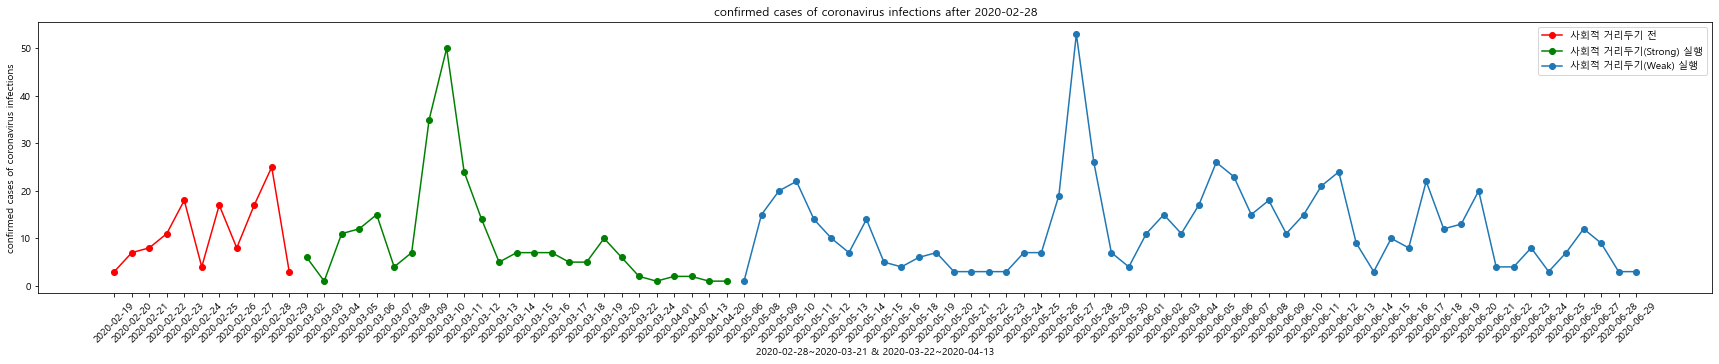

In [74]:
pr_pi
p1 = pr_pi.loc[(pr_pi.infection_case != 'overseas inflow')]
p2 = p1.loc[(p1.infection_case != 'contact with patient')]
p3 = p2.loc[(p2.infection_case != 'etc')]
p4 = p3.loc[(p2.infection_case != 'Shincheonji Church')]  # 신천지 107개 뺀 것!
p5 = p4.dropna()
group_infected = p5.groupby(['confirmed_date']).count()
group_infected

date = group_infected.index #날짜 column
count = group_infected['infection_case']

plt.figure()

plt.figure(figsize = (30,5))      

xbefore=date[0:11]
ybefore=count[0:11]

plt.plot(xbefore, ybefore, marker='o', color='r', label='사회적 거리두기 전')


xstrong=date[12:37]
ystrong=count[12:37]

plt.plot(xstrong, ystrong, marker='o', color='g', label='사회적 거리두기(Strong) 실행')

xafter=date[38:len(date)]
yafter=count[38:len(count)] 

plt.plot(xafter, yafter, marker='o', label='사회적 거리두기(Weak) 실행')

plt.xticks(rotation=45) #x축 글자 기울이기
plt.xlabel("2020-02-28~2020-03-21 & 2020-03-22~2020-04-13")
plt.ylabel("confirmed cases of coronavirus infections")
plt.title("confirmed cases of coronavirus infections after 2020-02-28")
plt.legend()
plt.show()


# 0125
# 0311
# 0529

In [75]:
# #사회적 거리두기 시행 이전 23일과 시행 이후 23일의 일별 확진자수를 시각화합니다.
# date = group_infected.index #날짜 column
# count = group_infected['infection_case']

# plt.figure()
# plt.rcParams['figure.figsize'] = [30, 5] # [width, height]

# plt.figure(figsize = (30,5))      
# #사회적 거리두기 이전 23일 동안의 확진자수 그래프 그리기
# xbefore=date[0:33] # 2월 28일 ~ 3월 21일을 x축으로 지정
# ybefore=count[0:33] # 2월 28일 ~ 3월 21일의 확진자수를 y축으로 지정

# plt.plot(xbefore, ybefore, marker='o', color='r', label='before social distancing(23 days)')

# #사회적 거리두기 이후 23일 동안의 확진자수 그래프 그리기
# xafter=date[33:len(date)] # 사회적 거리두기 시작일인 3월 22일부터 4월 13일을 x축으로 지정
# yafter=count[33:len(count)] # 사회적 거리두기 시작일인 3월 22일부터 4월 13일까지의 확진자수를 y축으로 지정

# plt.plot(xafter, yafter, marker='o', label='after social distancing(23 days)')

# plt.xticks(rotation=45) #x축 글자 기울이기
# plt.xlabel("2020-02-28~2020-03-21 & 2020-03-22~2020-04-13")
# plt.ylabel("confirmed cases of coronavirus infections")
# plt.title("confirmed cases of coronavirus infections after 2020-02-28")
# plt.legend()
# plt.show()


# # 0125
# # 0311
# # 0529

In [76]:
# 뚜렷한 변화를 찾기 힘드니
# 집단 감염을 유형별로 나눠
# 변화를 모색해보자

In [77]:
date_case_num = patient_info.groupby(['confirmed_date', 'infection_case'])[['patient_id']].count()

In [78]:
df = patient_info[['patient_id', 'confirmed_date', 'infection_case']]
df_sort = df.sort_values(by=['confirmed_date'])

# df_notna = df_sort[df_sort['confirmed_date'].notna()]
# df_etc = df_notna.replace(np.nan, 'etc', regex=True)
# df1 = df_etc.reset_index()

# df1.drop('index', axis='columns', inplace=True)
# df2 = df1.set_index('confirmed_date')
# df2

# nan값 다 빼버리기

df_sort.dropna(inplace=True)
df1 = df_sort.reset_index()
df2 = df1.drop('index', axis='columns')
df2

,patient_id,confirmed_date,infection_case
0,1400000001,2020-01-20,overseas inflow
1,1000000001,2020-01-23,overseas inflow
2,2000000001,2020-01-26,overseas inflow
3,2000000002,2020-01-27,overseas inflow
4,1000000003,2020-01-30,contact with patient
...,...,...,...
4238,1500000119,2020-06-30,etc
4239,1500000120,2020-06-30,contact with patient
4240,1500000121,2020-06-30,contact with patient
4241,1400000342,2020-06-30,overseas inflow


In [79]:
df2['infection_case'] = df2['infection_case'].replace({'Onchun Church' : '교회',
                                                      'Onchun Church' : '교회',
                                                      'Dongan Church' : '교회',
                                                      'Geochang Church' : '교회',
                                                      'Gangnam Dongin Church' : '교회',
                                                      'River of Grace Community Church' : '교회',
                                                      'SMR Newly Planted Churches Group' : '교회',
                                                      'Anyang Gunpo Pastors Group' : '교회',
                                                      'Wangsung Church' : '교회'})

df2['infection_case'] = df2['infection_case'].replace({'gym facility in Cheonan' : '운동/여가/모임',
                                                       'Yangcheon Table Tennis Club' : '운동/여가/모임',
                                                       'Changnyeong Coin Karaoke' : '운동/여가/모임',
                                                       'Gyeongsan Cham Joeun Community Center' : '운동/여가/모임',
                                                       'Biblical Language study meeting' : '운동/여가/모임',
                                                       'Gangnam Yeoksam-dong gathering' : '운동/여가/모임'})

df2['infection_case'] = df2['infection_case'].replace({'Guri Collective Infection' : '기타',
                                                       'Korea Campus Crusade of Christ' : '기타',
                                                       'Pilgrimage to Israel' : '기타',
                                                       'Yeongdeungpo Learning Institute' : '기타',
                                                       'Yeonana News Class' : '기타',
                                                       'Seocho Family' : '기타',
                                                       'Yongin Brothers' : '기타',
                                                       'Seongdong-gu APT' : '기타',
                                                       'Orange Town' : '기타'})

df2['infection_case'] = df2['infection_case'].replace({'contact with patient' : '확진자와 접촉'})

# 결측치, etc, 신천지, 이태원 뺐음

In [80]:
df3 = df2[(df2['infection_case'] == '기타') | (df2['infection_case'] == '운동/여가/모임') | (df2['infection_case'] == '교회')]

<ipython-input-81-13c3b734c02a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



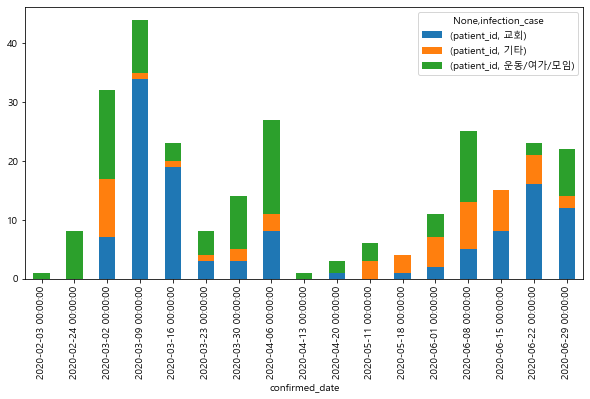

In [81]:
df3
df3['confirmed_date'] =  pd.to_datetime(df['confirmed_date'])
df4 = df3.groupby([pd.Grouper(key='confirmed_date', freq='W-MON'), 'infection_case']).count()

df4.unstack().plot(kind='bar', stacked=True ,figsize=(10,5))
# 0229 ~ 0419
# 0420 ~ 